In [1]:
%load_ext autoreload
%matplotlib inline

In [16]:
%autoreload 2

import sys,os,glob
print('Python version:',sys.version)
print('Conda environment:',os.environ['CONDA_DEFAULT_ENV'])
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
# matplotlib.use("PDF")
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
# from mpl_toolkits.basemap import Basemap
import xarray as xr
print("version of xarray:",xr.__version__)
# import dask
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(8))
import pickle
from pprint import pprint

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
repodir = workdir
while os.path.basename(repodir) != 'Fildier2020':
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from thermoConstants import *
from thermoFunctions import *
from statisticalDistributions import *
from scalingApproximations import *
from slicingAndSubsetting import *
from plot1DInvLog import *
from dataFormat import *
from importingData import *
from savingResults import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Python version: 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 22:45:16) 
[Clang 9.0.1 ]
Conda environment: pyLMD
version of xarray: 0.15.0
repo: /Users/bfildier/Code/analyses/Fildier2020
Own modules available: ['plot2D', 'dataFormat', 'slicingAndSubsetting', 'thermoFunctions', 'thermoFunctionsForMoistAdiabat', 'thermoConstants', 'savingResults', 'setEnv', 'importingData', 'thermoConstantsForMoistAdiabat', 'scalingApproximations', 'plot1DInvLog', 'statisticalDistributions']


In [17]:
archivedir = getArchivedir(machine='clarity')
resultdir = os.path.join(os.path.dirname(moduledir),'results')
figuredir = os.path.join(os.path.dirname(moduledir),'figures/paper')

if not os.path.exists(figuredir): os.makedirs(figuredir)

In [18]:
simname_patterns = 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r1',\
'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r1-b150-sfcagg',\
'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-r1-b150-sfcdisagg',\
'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-radhomo-r1-b100-radagg',\
'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST%d-radhomo-r1',\

simtypes = 'simOref','simFO','simFD','simQO','simDref'

simtype_labels = r'$\mathcal{O}_{ref}$',\
r'$\mathcal{O}(F_{\mathcal{O}_{ref}})$',\
r'$\mathcal{O}(F_{\mathcal{D}_{ref}})$',\
r'$\mathcal{D}(Q_{\mathcal{O}_{ref}})$',\
r'$\mathcal{D}_{ref}$',\

simtype_linetype = '--',':','-.','-','-'
simtype_markers = 'o','^','s','x','o'
sims2exclude = [(0,1),(0,2),(1,2),(2,2)]

SSTs = 300,302,304,306,308

# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

n_SSTs = len(SSTs)
n_sims = len(simname_patterns)

dt = 15 # s

vars4moist_profiles = ['LWD','LWU','QN','QP','QRAD','QV','TABS','W']

ndays = 50

In [19]:
def getExpname(simname):
    return simname.split('_')[-1]
def getSimroot(simname):
    return '_'.join(simname.split('_')[:-1])

In [20]:
print("Initialize stats for each simulation")

perc_ILQ_pr = {}
cdf_invlog_ILQ_pr = {}
err_perc_ILQ_pr = {}
ranks_ILQ_pr = {}
ds_STAT = {}
ds_2D = {}
moist_profiles = {}
dry_profiles = {}
wholeDomain_profiles = {}
areafrac_moist = {}
prQ_prof_conditionals = {}
epsFT = {}
pr_mean = {}
p_profile = {}

i_w24 = 5 # storage index for statistics computed over 24 time slices for rainfall pdfs

Initialize stats for each simulation


In [9]:
print("Import stats for each simulation")

load2D = False

for SST in SSTs:
    for i_sim in range(n_sims):
        
        simname = simname_patterns[i_sim]%SST
        
        print(simname)
        if not os.path.exists(os.path.join(archivedir,simname)):
            print('  skipped')
            continue

        # Define result folder
        expname = getExpname(simname)
        simroot = getSimroot(simname)
        resultsubdir = os.path.join(resultdir,simroot,expname)

        # Import precipitation statistics
#         if not (SST == 306 and i_sim in (1,2,3)):

        perc_ILQ_pr[simname] = pickle.load(open(os.path.join(resultsubdir,
                                                             'xy_stats_over_time',
                                                             'mean_percentiles_consec_sample_ILQ_pr.pickle'),'rb'))[i_w24]
        cdf_invlog_ILQ_pr[simname] = pickle.load(open(os.path.join(resultsubdir,
                                                             'xy_stats_over_time',
                                                             'mean_cdf_invlog_consec_sample_ILQ_pr.pickle'),'rb'))[i_w24]
        err_perc_ILQ_pr[simname] = pickle.load(open(os.path.join(resultsubdir,
                                                             'xy_stats_over_time',
                                                             'std_percentiles_consec_sample_ILQ_pr.pickle'),'rb'))[i_w24]
        ranks_ILQ_pr[simname] = pickle.load(open(os.path.join(resultsubdir,
                                                             'xy_stats_over_time',
                                                              'ranks_ILQ_pr.pickle'),'rb'))
        ranks = list(ranks_ILQ_pr[simname].values())[0]

        # Import model statistics
        if getCurrentMachine() != 'tornado':
            
            if not simname in ds_STAT.keys():
                filepattern_STAT = os.path.join(archivedir,simname,"OUT_STAT","%s.nc"%(simname))
                ds_STAT[simname] = xr.open_mfdataset(filepattern_STAT,decode_cf=False)
            
            if load2D:
                if not simname in ds_2D.keys():
                    varids_2D = ['PW','Prec']
                    varids2drop = ['PBLH','LWNS','LWNSC','LWNT','LWNTC','SOLIN','SWNS','SWNSC','SWNT','SWNTC','IWP','CLD','USFC',\
                         'U200','VSFC','V200','W500','W730','PSFC','SWVP','U850','V850','ZC','TB','ZE']
                    # Compute the number of processors
                    chunks = simname.split('_')
                    case = chunks[0]
                    Nxyz = chunks[3]
                    Nx,Ny,Nz = np.array(Nxyz.split('x'),dtype=int)
                    Nproc = np.max(np.array(Nxyz.split('x'),dtype=int))
                    # Get correct 2D data
                    filepattern_2D = os.path.join(archivedir,simname,"OUT_2D","%s_%s.2Dcom_*.nc"%(simname,Nproc))
                    ds_2D[simname] = xr.open_mfdataset(filepattern_2D,decode_cf=False,data_vars=varids_2D,\
                                                       drop_variables=varids2drop)

            # Mean rain
            pr_mean[simname] = np.mean(ds_STAT[simname].PREC.data[-ndays*24:]).compute()

            z_coord = xr.open_mfdataset(os.path.join(resultdir,'z.nc'),decode_cf=False).z

#         # Import moist conditionals
#         moist_profiles[simname] = {}
#         dry_profiles[simname] = {}
#         wholeDomain_profiles[simname] = {}
#         if 'radhomo' not in simname: # i.e. if it is organized
#             for varid in vars4moist_profiles:
#                 moist_profiles[simname][varid] = \
#                     pickle.load(open(os.path.join(resultsubdir,
#                                                   'moist_dry_conditionals',
#                                                   '%s_prof_time_mean_moist_80pct.pickle'%varid),'rb'))
#                 dry_profiles[simname][varid] = \
#                     pickle.load(open(os.path.join(resultsubdir,
#                                                   'moist_dry_conditionals',
#                                                   '%s_prof_time_mean_dry_80pct.pickle'%varid),'rb'))
#             areafrac_moist[simname] = pickle.load(open(os.path.join(resultsubdir,
#                                                   'moist_dry_conditionals',
#                                                   'areafrac_moist_80pct.pickle'),'rb'))

#         if '-b150-' not in simname:
#             for varid in vars4moist_profiles:
#                 wholeDomain_profiles[simname][varid] = \
#                             pickle.load(open(os.path.join(resultsubdir,
#                                               'moist_dry_conditionals',
#                                               '%s_prof_time_mean_wholeDomain.pickle'%varid),'rb'))

        # Import conditional averages
        if simname not in prQ_prof_conditionals.keys():
            prQ_prof_conditionals[simname] = {}

            prQ_prof_conditionals[simname]['QV'] = \
                        pickle.load(open(os.path.join(resultsubdir,
                                                      'dynamic_thermo_contributions',
                                                      'qv_prof_FTscaling_prQ.pickle'),'rb'))
            prQ_prof_conditionals[simname]['W'] = \
                        pickle.load(open(os.path.join(resultsubdir,
                                                      'dynamic_thermo_contributions',
                                                      'w_prof_FTscaling_prQ.pickle'),'rb'))
            prQ_prof_conditionals[simname]['TABS'] = \
                        pickle.load(open(os.path.join(resultsubdir,
                                                      'dynamic_thermo_contributions',
                                                      'tabs_prof_FTscaling_prQ.pickle'),'rb'))
#         # Import epsilon factor
#         epsFT[simname] = pickle.load(open(os.path.join(resultsubdir,
#                                                        'dynamic_thermo_contributions',
#                                                        'alpha_FTscaling.pickle'),'rb'))
            
#         if simname not in ['RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST306-r1-b150-sfcagg',
#                            'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST306-r1-b150-sfcdisagg',
#                            'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST306-radhomo-r1-b100-radagg']:
        p_profile[simname] = \
                    pickle.load(open(os.path.join(resultsubdir,
                                                  'dynamic_thermo_contributions',
                                                  'p_prof_FTscaling.pickle'),'rb'))

Import stats for each simulation
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
  skipped
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
  skipped
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
  skipped
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1-b100-radagg
  skipped
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
  skipped
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1
  skipped
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcagg
  skipped
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg
  skipped
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r1-b100-radagg
  skipped
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r1
  skipped
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1
  skipped
RCE_MPDATAxTKExCAMxSAM1MOM_4000x

In [8]:
def lastDay(simname):
    
    # Choose daymax
    daymax = 150
    if 'radhomo' in simname or '-sfc'in simname:
        daymax = 100
    # Check times available in 2D file and update time range if necessary
    if daymax > min(ds_2D[simname]['time'][-1],ds_STAT[simname]['time'][-1]) :
        # adjust daymax
        daymax_STAT = float(floor(ds_STAT[simname]['time'][-1]))
        daymax_2D = float(floor(ds_2D[simname]['time'][-1]))
        daymax = min(daymax_STAT,daymax_2D)
    
    return daymax

In [9]:
print()
print("Load the 3D file corresponding to the last time saved in both ds_STAT and ds_2D for each simulation")
print()

ds_3D_last = {}

for SST in SSTs:
    for simname_pattern in simname_patterns:
        
        simname = simname_pattern%SST
    
        print('--',simname)

        # Define result folder
        expname = getExpname(simname)
        simroot = getSimroot(simname)
        
        if simname in ds_STAT.keys() and simname in ds_2D.keys():
            
            # Choose daymax
            daymax = lastDay(simname)
            
            # Convert time from day to time step
            stepmax = int(daymax*24*3600/dt)
            stepmin = int((daymax-1)*24*3600/dt)
            # Extract 3D variables at that timestep
            steprange = (stepmin,stepmax)
            print(steprange)
            files_in_steprange = get3DFilesBetweenSteps(archivedir,simname,steprange)
#             print("# of files present:",len(files_in_steprange))
#             print()
            ds_3D_last[simname] = xr.open_mfdataset(files_in_steprange,decode_cf=False)


Load the 3D file corresponding to the last time saved in both ds_STAT and ds_2D for each simulation

-- RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
-- RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
-- RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
-- RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1-b100-radagg
-- RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
-- RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1
-- RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcagg
-- RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg
-- RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r1-b100-radagg
-- RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r1
-- RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1
-- RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x

In [9]:
# Import scaling and fractional changes

cross_scaling_ILQ_pr = pickle.load(open(os.path.join(resultdir,
                                              'dynamic_thermo_contributions',
                                              'cross_scaling_for_fracchange_prQ_and_contributions.pickle'),'rb'))
frac_change_ILQ_pr = pickle.load(open(os.path.join(resultdir,
                                              'dynamic_thermo_contributions',
                                              'fractionalChanges_prQ_and_contributions.pickle'),'rb'))
frac_change_fullDec_ILQ_pr = pickle.load(open(os.path.join(resultdir,
                                              'dynamic_thermo_contributions',
                                              'fractionalChanges_prQ_and_contributions_fullDec.pickle'),'rb'))

Qmax = 99.99
iQmax = indexOfRank(Qmax,ranks)
sQ = slice(0,iQmax)
sQ9999 = slice(0,indexOfRank(99.99,ranks))
sQ99999 = slice(0,indexOfRank(99.999,ranks))
ranks_ref = ranks[sQ]
ranks_9999 = ranks[sQ9999]
ranks_99999 = ranks[sQ99999]

Qref = 99.9
iQref = indexOfRank(Qref,ranks)
sQext = slice(indexOfRank(99.9,ranks_ref),indexOfRank(99.99,ranks_ref))

In [10]:
print('Fractional changes in rainfall intensities and exceedance amounts')

# Compute fractional changes
fracchange_camountIL = {}
fracchange_percIL = {}

SST_pairs = (300,302),\
            (302,304),\
            (304,306),\
            (306,308),\
            (300,304),\
            (302,306)

for SST_pair in SST_pairs:
    print(SST_pair)
    
    SST_cold = SST_pair[0]
    SST_warm = SST_pair[1]
    dT = SST_warm-SST_cold
    
    for i_sim in range(n_sims):

        simname_cold = simname_patterns[i_sim]%SST_cold
        simname_warm = simname_patterns[i_sim]%SST_warm
        
        if not simname_cold in cdf_invlog_ILQ_pr.keys():
            print("no CDF_IL data for",simname_cold)
            continue
        if not simname_warm in cdf_invlog_ILQ_pr.keys():
            print("no CDF_IL data for",simname_warm)
            continue
        
        key = "%s_%s"%(simname_cold,simname_warm)

        fracchange_camountIL[key] = np.nan*np.zeros((iQmax,))
        fracchange_percIL[key] = np.nan*np.zeros((iQmax,))
        for iQ in range(iQmax):
            
            cdf_invlog_cold = pr_mean[simname_cold]*cdf_invlog_ILQ_pr[simname_cold]
            cdf_invlog_warm = pr_mean[simname_warm]*cdf_invlog_ILQ_pr[simname_warm]
            
            if cdf_invlog_cold[iQ] != 0:
                fracchange_camountIL[key][iQ] = (cdf_invlog_warm[iQ]/\
                                                 cdf_invlog_cold[iQ]-1)/dT*100
            if perc_ILQ_pr[simname_cold][iQ] != 0:
                fracchange_percIL[key][iQ] = (perc_ILQ_pr[simname_warm][iQ]/\
                                              perc_ILQ_pr[simname_cold][iQ]-1)/dT*100

Fractional changes in rainfall intensities and exceedance amounts
(300, 302)
(302, 304)
(304, 306)
(306, 308)
(300, 304)
(302, 306)


$$P^Q \approx \exp\left(a^Q T + b^Q\right)$$

In [11]:
print('Linearly regressed fractional changes in rainfall intensities and exceedance amounts')

fracchange_mean_camountIL = {}
fracchange_mean_percIL = {}
fracchange_mean_prmean = {}
offset_camountIL = {}
offset_percIL = {}
offset_prmean = {}

for i_sim in range(n_sims):
    
    key = simtypes[i_sim]
    print(' .  ',key)
    
    fracchange_mean_camountIL[key] = np.nan*np.zeros((iQmax,))
    offset_camountIL[key] = np.nan*np.zeros((iQmax,))
    fracchange_mean_percIL[key] = np.nan*np.zeros((iQmax,))
    offset_percIL[key] = np.nan*np.zeros((iQmax,))
        
    # SSTs to consider
    sst_values = []
    for i_SST in range(n_SSTs):
        if not (i_SST,i_sim) in sims2exclude:

            sst_values.append(SSTs[i_SST])
    
    # For each percentile, do the calculation
    for iQ in range(iQmax):        
    
        percIL_values = []
        camountIL_values = []

        # For each SST, store precip data
        for SST in sst_values:
            
            simname = simname_patterns[i_sim]%SST
            
            camountIL_values.append(pr_mean[simname]*cdf_invlog_ILQ_pr[simname][iQ])
            percIL_values.append(perc_ILQ_pr[simname][iQ])

        # Regress ln(pr) against T for percentiles
        slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(percIL_values))
        fracchange_mean_percIL[key][iQ] = slope
        offset_percIL[key][iQ] = intercept
        # Regress ln(pr) against T for rain amounts
        slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(camountIL_values))
        fracchange_mean_camountIL[key][iQ] = slope
        offset_camountIL[key][iQ] = intercept
    
    prmean_values = []
    # For each SST, store precip data
    for SST in sst_values:
        simname = simname_patterns[i_sim]%SST
        prmean_values.append(pr_mean[simname])

    # Regress ln(pr) against T for mean rain 
    slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(prmean_values))
    fracchange_mean_prmean[key] = slope
    offset_prmean[key] = intercept
        
        

Linearly regressed fractional changes in rainfall intensities and exceedance amounts
 .   simOref


/global/homes/b/bfildier/anaconda3/envs/pyPhD/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log
/global/homes/b/bfildier/anaconda3/envs/pyPhD/lib/python3.6/site-packages/numpy/lib/function_base.py:3087: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


 .   simFO
 .   simFD
 .   simQO
 .   simDref


# Snapshots as a function of simulation type and SST

In [13]:

def plotSnapshots2DVsSSTandSimtype(axes,dict_2Darrays,SSTs,simtypes,fs_biglabs=18,vmin=None,vmax=None,\
                                   cmap=plt.cm.magma_r,extent=[0,1024,0,1024]):

    # # Subplot spacing
    # plt.tight_layout(pad=-1)

    showVar = True
    x_left = np.nan
    x_right = np.nan
    y_bot = np.nan
    y_top = np.nan

    for i_SST in range(n_SSTs):

        SST = SSTs[i_SST]
        
        print(SST)

        for i_sim in range(n_sims):
            
            simtype = simtypes[i_sim]

            ax = axes[i_SST,i_sim]
            print(simtype,end=' | ')

            # Save boundaries for legend
            x,y,w,h = ax.get_position().bounds
            x_left = np.nanmin(np.array([x,x_left]))
            x_right = np.nanmax(np.array([x+w,x_right]))
            y_bot = np.nanmin(np.array([y,y_bot]))
            y_top = np.nanmax(np.array([y+h,y_top]))

            # show snapshot
            array = dict_2Darrays[SST][simtype]
            images = []
            if simname in ds.keys():
                if showVar:
                    im = ax.imshow(array,
                                   cmap=cmap,
                                   vmin=vmin,vmax=vmax,
                                   extent=extent)
                    images.append(im)

            # add titles
            if i_SST == 0:
                ax.set_title(simtype_labels[i_sim],fontsize=fs_biglabs,pad=15)
            # choose axis labels
            if i_SST == n_SSTs-1:
                ax.set_xlabel('x (km)')
            else:
                ax.set_xticklabels([])
            if i_sim == n_sims-1:
                ax.set_ylabel('y (km)')
            else:
                ax.set_yticklabels([])
            # choose axis position
            ax.yaxis.set_label_position("right")
            ax.yaxis.set_ticks_position('right')
        
            # Mark in bold the simulations to use
            if (i_SST,i_sim)  in sims2exclude:
                [i.set_linestyle(':') for i in ax.spines.values()]
                [i.set_linewidth(2) for i in ax.spines.values()]

        # End of line
        print()

    # Add row labels
    pad = 5 # in points
    rows = ['{} K'.format(SST) for SST in SSTs]

    for ax, row in zip(axes[:,0], rows):
    #     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
    #                 xycoords=ax.yaxis.label, textcoords='offset points',
    #                 fontsize=18, ha='right', va='center')
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords='axes fraction', textcoords='offset points',
                    fontsize=fs_biglabs, ha='right', va='center')

    # Color bar
    dy = (y_top-y_bot)/60
    cax = plt.axes([x_left,y_bot-6*dy,x_right-x_left,dy])
    cbar = fig.colorbar(images[0], cax=cax, orientation='horizontal')
    cbar.ax.set_xlabel('%s (%s)'%(ds_2D[simname][varid2D].long_name,ds_2D[simname][varid2D].units),fontsize=fs_biglabs)


## PW, or any varid in ds_2D

In [20]:
print("Create dictionary of images to plot")

dict_array = {}

Create dictionary of images to plot


In [21]:
print("Add variable to dictionary of images")

varid2D = 'PW'

if varid2D not in dict_array.keys():
    
    dict_array[varid2D] = {}

    for i_SST in range(n_SSTs):

        SST = SSTs[i_SST]
        dict_array[varid2D][SST] = {}

        for i_sim in range(n_sims):

            simname = simname_patterns[i_sim]%SST
            simtype = simtypes[i_sim]
            
            ax = axes[i_SST,i_sim]
            print(simname)
        
            # show snapshot
            ds = ds_2D
            if simname in ds.keys():
                dict_array[varid2D][SST][simtype] = ds[simname][varid2D].data[-1]
                    
                    

Add variable to dictionary of images
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1-b100-radagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r1-b100-radagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcagg
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304

300
simOref | simFO | simFD | simQO | simDref | 
302
simOref | simFO | simFD | simQO | simDref | 
304
simOref | simFO | simFD | simQO | simDref | 
306
simOref | simFO | simFD | simQO | simDref | 
308
simOref | simFO | simFD | simQO | simDref | 


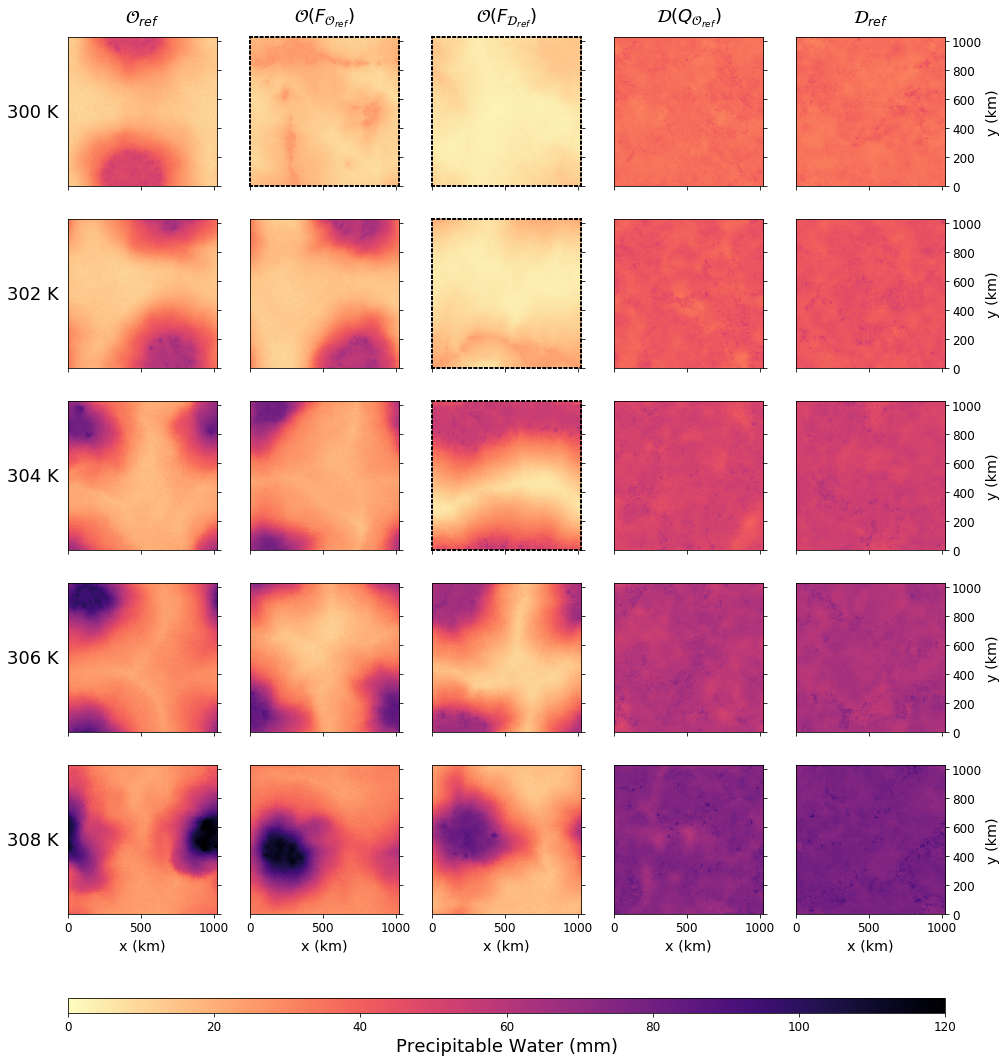

In [25]:
varid2D = 'PW'
vmin = 0
vmax = 120

# fontsize
fs_biglabs = 18

sims2exclude = [(0,1),(0,2),(1,2),(2,2)]

fig,axes = plt.subplots(nrows=n_SSTs,ncols=n_sims,figsize=(12.5,12.5))

# Subplot spacing
plt.tight_layout(pad=-1)

# Show
plotSnapshots2DVsSSTandSimtype(axes,dict_array[varid2D],SSTs,simtypes,vmin=vmin,vmax=vmax)

plt.savefig(os.path.join(figuredir,'snapshots_SST_vs_simtype_%s.pdf'%varid2D),
                bbox_inches='tight')
plt.show()

## Vertically-integrated RH, or any varid in ds_3D

In [18]:
print("Create dictionary of 3D images (integrated in z) to plot")

dict_array3D = {}

Create dictionary of 3D images (integrated in z) to plot


In [1]:
print("Add variable to dictionary of images")

varid3D = 'RH'

if varid3D not in dict_array3D.keys():
    
    dict_array3D[varid3D] = {}

    for i_SST in range(n_SSTs):

        SST = SSTs[i_SST]
        dict_array3D[varid3D][SST] = {}
        
        print(SST)

        for i_sim in range(n_sims):

            simname = simname_patterns[i_sim]%SST
            simtype = simtypes[i_sim]
            
            print(simtype,end=' | ')
        
            # show snapshot
            ds = ds_3D_last
            if simname in ds.keys():
                if varid3D == 'RH':
                    # Calculate relative humidity
                    tabs = ds[simname]['TABS'].data[-1]
                    qv = ds[simname]['QV'].data[-1]/1000 # kg/kg
                    pres1D = p_profile[simname]*101.3 # Pa
                    Nx,Ny = qv.shape[-2:]
                    pres3D = np.stack([np.stack([pres1D]*Nx,axis=-1)]*Ny,axis=-1)
                    qvstar = saturationSpecificHumidity(pres=pres3D,temp=tabs)
                    relhum = qv/qvstar
                    # compute vertical integral
                    intRH2D = verticalPressureIntegral(pres3D,relhum,levdim=0)/verticalPressureIntegral(pres3D,levdim=0)

                    # Save image
                    dict_array3D[varid3D][SST][simtype] = intRH2D
                    
                    # Delete heavy local variables
                    for key in 'tabs','qv','pres1D','pres3D','qvstar','relhum':
                        del locals()[key]

        # End of line
        print()

Add variable to dictionary of images


NameError: name 'dict_array3D' is not defined

# Distributions

## Percentiles with scaling

KeyError: 'prQ'

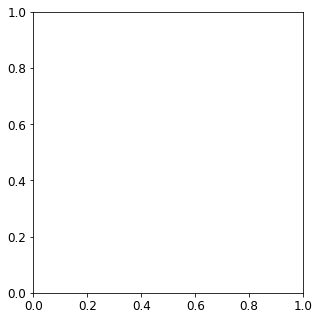

In [42]:
s = sQ
# SST = 300


contributions2plot = 'prQ_cold','cold'
lt = ['-',':']


fig,ax = plt.subplots(ncols=1,figsize=(5,5))
# ax.set_ylim((0,18))

i_sim = 0 # Oref

for i_SST in range(n_SSTs):
    
    SST = SSTs[i_SST]

    simname = simname_patterns[i_sim]%SST

    subplotRanksILog(ax,ranks[s],
                     cross_scaling_ILQ_pr[simname]['prQ'][s],
                     col='k',
                     ltype='-',
                     labels=r'Extreme rain $P^Q$',
                     transformX=False)
    subplotRanksILog(ax,ranks[s],
                     cross_scaling_ILQ_pr[simname]['alpha_cold']*cross_scaling_ILQ_pr[simname]['cold'][s]*86400,
                     col='k',
                     ltype=':',
                     labels="Scaling",
                     transformX=True)

# x = np.flipud(1./(1-ranks[:-1]/100.))
# addYLine(ax,x,y0=-1)

ax.legend(loc='best',fontsize=13)
ax.set_xlabel('Rank (%)')
ax.set_ylabel(r'Percentile $P^Q$ (mm/day)')

# Crop x-axis
iQ_min = 8
x = np.flipud(1./(1-ranks[sQ]/100.))
ax.set_xlim((x[iQ_min-1],0.8))

# plt.savefig(os.path.join(figuredir,'percentiles_and_scaling_disagg_%d.pdf'%SST),
#             bbox_layout='tight')
# plt.show()

## 4 panels distributions

RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1


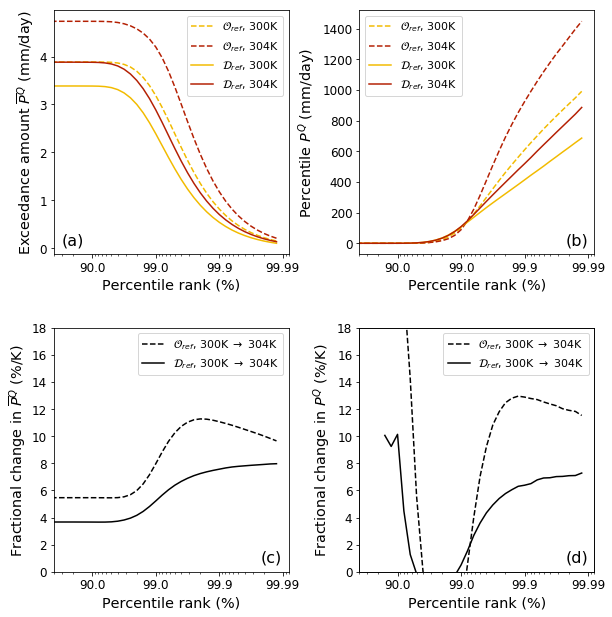

In [21]:
# c = ['k','purple']
lt = ['--','-']

fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(10,10))

SST_inds = (0,2)
# SST_inds = (1,3)
SSTs2plot = SSTs[SST_inds[0]],SSTs[SST_inds[1]]
sim_inds = np.array((0,4))
    
for i_sim in sim_inds:
    
    for i_SST in SST_inds:
        
        SST = SSTs[i_SST]
    
        simname = simname_patterns[i_sim]%SST
        simlab = simtype_labels[i_sim]+', %dK'%SST
        print(simname)

        cdf_invlog = pr_mean[simname]*cdf_invlog_ILQ_pr[simname]

        # panel (a)
        subplotRanksILog(axs[0,0],ranks_9999,
                         cdf_invlog[sQ9999],
                         col=SST_col[i_SST],
                         ltype=simtype_linetype[i_sim],
                         labels=simlab,
                         transformX=False)
        
        # panel (b)
        subplotRanksILog(axs[0,1],ranks_9999,
                         perc_ILQ_pr[simname][sQ9999],
                         col=SST_col[i_SST],
                         ltype=simtype_linetype[i_sim],
                         labels=simlab,
                         transformX=False)

    
    key = "%s_%s"%(simname_patterns[i_sim]%SSTs2plot[0],
                   simname_patterns[i_sim]%SSTs2plot[1])
    keylabel = simtype_labels[i_sim]+r", %dK $\rightarrow$ %dK"%tuple(SSTs2plot)
    
    # panel (c)
    subplotRanksILog(axs[1,0],ranks_ref,
                     fracchange_camountIL[key][sQ9999],
                     col='k',
                     ltype=simtype_linetype[i_sim],
                     labels=keylabel,
                     transformX=False)
    
    # panel (d)
    subplotRanksILog(axs[1,1],ranks_ref,
                     fracchange_percIL[key][sQ9999],
                     col='k',
                     ltype=simtype_linetype[i_sim],
                     labels=keylabel,
                     transformX=False)


x = np.flipud(1./(1-ranks_ref/100.))
# Deal with np.nans at the beginning of panel (d)
addYLine(axs[1,1],x,y0=-35)

for ax in axs.flatten():
    # add legend
    ax.legend(fontsize=11)
    # add x labels
    ax.set_xlabel('Percentile rank (%)')
    # transform x axis
    transformXaxisIL(ax,x)
    # crop axis
    iQ_min = 4
    ax.set_xlim((x[iQ_min-1],0.8))

    
axs[0,0].set_ylabel(r'Exceedance amount $\overline{P}^Q$ (mm/day)')
axs[0,1].set_ylabel(r'Percentile $P^Q$ (mm/day)')
axs[1,0].set_ylabel(r'Fractional change in $\overline{P}^Q$ (%/K)')
axs[1,1].set_ylabel(r'Fractional change in $P^Q$ (%/K)')

axs[1,0].set_ylim((0,18))
axs[1,1].set_ylim((0,18))

##-- Panel numbers
axs[0,0].text(0.03,0.04,'(a)',transform = axs[0,0].transAxes,fontsize=16)
axs[0,1].text(0.88,0.04,'(b)',transform = axs[0,1].transAxes,fontsize=16)
axs[1,0].text(0.88,0.04,'(c)',transform = axs[1,0].transAxes,fontsize=16)
axs[1,1].text(0.88,0.04,'(d)',transform = axs[1,1].transAxes,fontsize=16)

plt.savefig(os.path.join(figuredir,'distributions_org_disorg_%d_%d.pdf'%tuple(SSTs2plot)),
                bbox_inches='tight')

plt.show()

## Extremes vs. SST

KeyError: 'RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1'

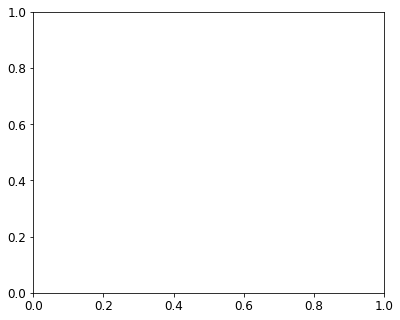

In [15]:
simtype_col = 'k','b','r','g','k'
sims2exclude = [(0,1),(0,2),(1,2),(2,2)]

# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

dT = 0.1
x_vals = np.arange(SSTs[0]-1,SSTs[-1]+1,dT)
rate = 0.08
# y_vals_norm = np.exp(rate*x_vals)
y_vals_ref = saturationVaporPressure(temp=x_vals)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6.5,5))

##--- Draw exponential fits
for i_sim in range(n_sims):

    simtype = simtypes[i_sim]

    if i_sim in (0,4):
#             x_ssts,y_pr = getExponentialSSTCurve(i_sim,fracchange_mean_percIL,offset_percIL,iQref)
        #-- Recompute manually

        # SSTs 
        sst_values = []
        pr_values = []
        for i_SST in range(n_SSTs):
            if not (i_SST,i_sim) in sims2exclude:
                sst_values.append(SSTs[i_SST])
                simname = simname_patterns[i_sim]%SSTs[i_SST]
                pr_values.append(np.mean(perc_ILQ_pr[simname][sQext]))
        sst_values = np.array(sst_values)
        pr_values = np.array(pr_values)
        print(pr_values)
        # exp fit
        slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(pr_values))
        #-- Values to plot
        x_ssts = np.linspace(sst_values[0]-1,sst_values[-1]+1,100)
        y_pr = np.exp(slope*x_ssts+intercept)
        # Draw
        ax.plot(x_ssts,y_pr,linestyle=simtype_linetype[i_sim],linewidth=1.5,c='k')

        
##--- Draw points and CC curves
for i_SST in range(n_SSTs):
    
    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
        
        simname = simname_patterns[i_sim]%SST
        simtype = simtypes[i_sim]
        
        # Skip dot/curve if simulation didn't reach equilibrium
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        if simname in perc_ILQ_pr.keys():
#             print("%dK, %s:"%(SST,simtype_labels[i_sim]),perc_ILQ_pr[simname][iQref])
#             x,y = SST,perc_ILQ_pr[simname][iQmax]
            # Mean over percentiles
            x,y = SST,np.mean(perc_ILQ_pr[simname][sQext])
            # Reference 99.9th percentile
#             x,y = SST,perc_ILQ_pr[simname][iQref]
            
            #--- Draw CC curves
            if i_sim in (0,4): 
                # Assuming a fixed rate
    #             y_vals = y_vals_norm*y*np.exp(-rate*x)

                # Assuming the CC formula
                i_x = np.argmin(np.abs(x_vals - float(SST)))
                y_vals = y_vals_ref/y_vals_ref[i_x]*y
                print("%2.5f"%((np.diff(y_vals)[i_x]/y_vals[i_x])/dT))

                ax.plot(x_vals,y_vals,linestyle=simtype_linetype[i_sim],\
                        c=SST_col[i_SST],linewidth=0.9,alpha=0.6)
                
            #--- Draw points
            # Define color
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = SST_col[i_SST]
            # Define marker width
            mw = 1
            if i_sim == 0:
                mw = 2
            # Define legend label
            if SST == SSTs[-1]:
                lab = simtype_labels[i_sim]
            else:
                lab = ''
            # Show point
            ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=SST_col[i_SST],\
                    markeredgewidth=mw,label=lab)

ax.set_xlabel('SST (K)')
ax.set_ylabel(r'99.9th percentile $P^{99.9}$ (mm/day)')
ax.legend(fontsize=12)

# Color bar
cax, _ = matplotlib.colorbar.make_axes(ax)
normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

plt.savefig(os.path.join(figuredir,'P999_vs_SST_allsims.pdf'),
                bbox_inches='tight')
plt.show()

passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg
[  783.78395005   900.26927082  1169.65584996  1239.99574402  1508.94211444]
[ 534.2235326   608.30931744  681.52309359  764.37132988  833.37100675]
0.05893
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
0.05893
0.05805
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg
0.05805
0.05719
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg
0.05719
0.05634
0.05634
0.05551
0.05551


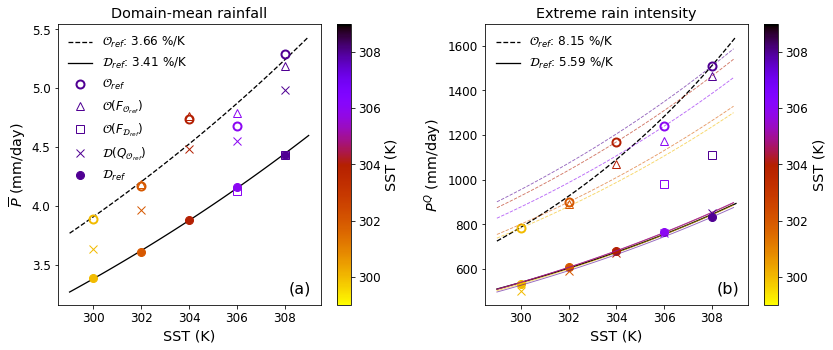

In [22]:
simtype_col = 'k','b','r','g','k'
sims2exclude = [(0,1),(0,2),(1,2),(2,2)]


def getExponentialSSTCurve(i_sim,slopes,offsets,iQ=None):

    simtype = simtypes[i_sim]
    # SSTs to consider
    sst_values = []
    for i_SST in range(n_SSTs):
        if not (i_SST,i_sim) in sims2exclude:
            sst_values.append(SSTs[i_SST])
    sst_values = np.array(sst_values)
    # curve points
    x = np.linspace(sst_values[0]-1,sst_values[-1]+1,100)
    if iQ is None:
        y = np.exp(slopes[simtype]*x + offsets[simtype])
    else:
        y = np.exp(slopes[simtype][iQ]*x + offsets[simtype][iQ])
    
    return x,y
    
# legend font size
ftsize = 12
# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 299.
SSTmax = 309.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

# Compute CC rates at each temperature
dT = 0.1
x_vals = np.arange(SSTs[0]-1,SSTs[-1]+1,dT)
rate = 0.08
# y_vals_norm = np.exp(rate*x_vals)
y_vals_ref = saturationVaporPressure(temp=x_vals)


fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(14,5))

##---- Panel (a): mean P
ax = axs[0]
# ax.set_ylim((3.2,5.9))

##--- Draw exponential fits
for i_sim in range(n_sims):
    
    if i_sim in (0,4):
        
        simtype = simtypes[i_sim]

        x_ssts,y_pr = getExponentialSSTCurve(i_sim,fracchange_mean_prmean,offset_prmean)
        
#         lab = 'Exponential fit, '+simtype_labels[i_sim]+'%2.2f'%(fracchange_mean_prmean[simtype]*100)+'%/K'
#         lab = 'Exponential trend, '+simtype_labels[i_sim]+': %2.2f'%(fracchange_mean_prmean[simtype]*100)+' %/K'
        lab = simtype_labels[i_sim]+': %2.2f'%(fracchange_mean_prmean[simtype]*100)+' %/K'
        ax.plot(x_ssts,y_pr,linestyle=simtype_linetype[i_sim],linewidth=1.3,c='k',label=lab)
        
for i_SST in range(n_SSTs):
    
    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
        
        simname = simname_patterns[i_sim]%SST
        
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        if simname in pr_mean.keys():
            
            x,y = SST,pr_mean[simname]
            
            #--- Draw points
            # Define color
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = SST_col[i_SST]
            # Define marker width
            mw = 1
            if i_sim == 0:
                mw = 2
            # Define legend label
            if SST == SSTs[-1]:
                lab = simtype_labels[i_sim]
            else:
                lab = ''
            # Show point
            ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=SST_col[i_SST],\
                    markeredgewidth=mw,label=lab)
            
ax.legend(fontsize=ftsize,framealpha=0)
            
##---- Panel (b): extreme P ----##
ax = axs[1]
# ax.set_ylim((450,1850))

##--- Draw exponential fits
for i_sim in range(n_sims):

    simtype = simtypes[i_sim]

    if i_sim in (0,4):
#             x_ssts,y_pr = getExponentialSSTCurve(i_sim,fracchange_mean_percIL,offset_percIL,iQref)
        #-- Recompute manually

        # SSTs 
        sst_values = []
        pr_values = []
        for i_SST in range(n_SSTs):
            if not (i_SST,i_sim) in sims2exclude:
                sst_values.append(SSTs[i_SST])
                simname = simname_patterns[i_sim]%SSTs[i_SST]
                pr_values.append(np.mean(perc_ILQ_pr[simname][sQext]))
        sst_values = np.array(sst_values)
        pr_values = np.array(pr_values)
        print(pr_values)
        # exp fit
        slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(pr_values))
        #-- Values to plot
        x_ssts = np.linspace(sst_values[0]-1,sst_values[-1]+1,100)
        y_pr = np.exp(slope*x_ssts+intercept)
        # Draw
#         lab = 'Exponential trend, '+simtype_labels[i_sim]+': %2.2f'%(slope*100)+' %/K'
        lab = simtype_labels[i_sim]+': %2.2f'%(slope*100)+' %/K'
        ax.plot(x_ssts,y_pr,linestyle=simtype_linetype[i_sim],linewidth=1.3,c='k',label=lab)

        
##--- Draw points and CC curves
for i_SST in range(n_SSTs):
    
    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
        
        simname = simname_patterns[i_sim]%SST
        simtype = simtypes[i_sim]
        
        # Skip dot/curve if simulation didn't reach equilibrium
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        if simname in perc_ILQ_pr.keys():
#             print("%dK, %s:"%(SST,simtype_labels[i_sim]),perc_ILQ_pr[simname][iQref])
#             x,y = SST,perc_ILQ_pr[simname][iQmax]
            # Mean over percentiles
            x,y = SST,np.mean(perc_ILQ_pr[simname][sQext])
            # Reference 99.9th percentile
#             x,y = SST,perc_ILQ_pr[simname][iQref]
            
            #--- Draw CC curves
            if i_sim in (0,4): 
                # Assuming a fixed rate
    #             y_vals = y_vals_norm*y*np.exp(-rate*x)

                # Assuming the CC formula
                i_x = np.argmin(np.abs(x_vals - float(SST)))
                y_vals = y_vals_ref/y_vals_ref[i_x]*y
                print("%2.5f"%((np.diff(y_vals)[i_x]/y_vals[i_x])/dT))

                ax.plot(x_vals,y_vals,linestyle=simtype_linetype[i_sim],\
                        c=SST_col[i_SST],linewidth=0.9,alpha=0.6)
                
            #--- Draw points
            # Define color
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = SST_col[i_SST]
            # Define marker width
            mw = 1
            if i_sim == 0:
                mw = 2
            # Define legend label
            if SST == SSTs[-1]:
#                 lab = simtype_labels[i_sim]
                lab = ''
            else:
                lab = ''
            # Show point
            ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=SST_col[i_SST],\
                    markeredgewidth=mw,label=lab)

for ax in axs:
    
    ax.set_xlabel('SST (K)')
    
    # Color bar
    cax, _ = matplotlib.colorbar.make_axes(ax)
    normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,label='SST (K)')

axs[0].set_ylabel(r'$\overline{P}$ (mm/day)')
# axs[1].set_ylabel(r'99.9th percentile $P^{99.9}$ (mm/day)')
axs[1].set_ylabel(r'$P^Q$ (mm/day)')

axs[0].set_title(r'Domain-mean rainfall')
axs[1].set_title(r'Extreme rain intensity')

# axs[1].legend(ncol=2,fontsize=11)
axs[1].legend(ncol=1,fontsize=ftsize,framealpha=0)

##-- Panel numbers
axs[0].text(0.88,0.04,'(a)',transform = axs[0].transAxes,fontsize=16)
axs[1].text(0.88,0.04,'(b)',transform = axs[1].transAxes,fontsize=16)

plt.savefig(os.path.join(figuredir,'meanP_P999_vs_SST_allsims.pdf'),
                bbox_inches='tight')
plt.show()

## Mean vars vs. SST

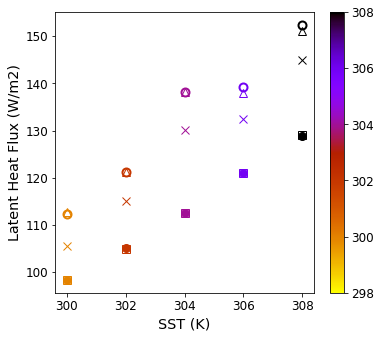

In [50]:
simtype_col = 'k','b','r','g','k'
sims2exclude = [(0,1),(0,2),(1,2),(2,2)]

# Var to plot
varids = 'PREC','SHF', 'LHF'
varlabels = 'Mean P', 'Sensible Heat Flux','Latent Heat Flux'
i_var = 2
varid = varids[i_var]

# N days for averaging
ndays = 50

# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 298.
SSTmax = 308.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

dT = 0.1
x_vals = np.arange(SSTs[0]-1,SSTs[-1]+1,dT)
rate = 0.08
# y_vals_norm = np.exp(rate*x_vals)
y_vals_ref = saturationVaporPressure(temp=x_vals)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,5))

for i_SST in range(n_SSTs):
    
    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
        
        simname = simname_patterns[i_sim]%SST
        
#         if (i_SST,i_sim) in sims2exclude:
#             print("passing %s"%simname)
#             continue
        
        if simname in perc_ILQ_pr.keys():
            x,y = SST,np.mean(ds_STAT[simname][varid][-24*ndays:],axis=0)

            # Show points
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = SST_col[i_SST]
            mw = 1
            if i_sim == 0:
                mw = 2
            ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=SST_col[i_SST], markeredgewidth=mw)

ax.set_xlabel('SST (K)')
ax.set_ylabel(r'%s (%s)'%(varlabels[i_var],ds_STAT[simname][varid].units))

# Color bar
cax, _ = matplotlib.colorbar.make_axes(ax)
normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

plt.savefig(os.path.join(figuredir,'%s_vs_SST_allsims.pdf'%varid),
                bbox_inches='tight')
plt.show()

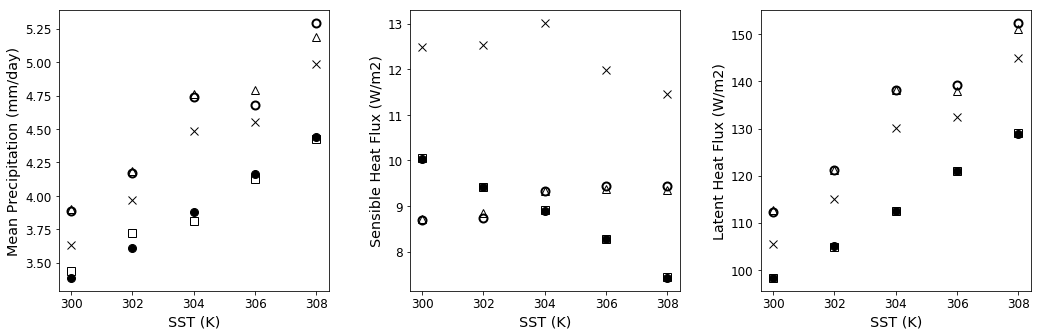

In [51]:
simtype_col = 'k','b','r','g','k'

# Var to plot
varids = 'PREC','SHF', 'LHF'
varlabels = 'Mean Precipitation', 'Sensible Heat Flux','Latent Heat Flux'

# N days for averaging
ndays = 50

# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 298.
SSTmax = 308.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

fig,axs = plt.subplots(nrows=1,ncols=len(varids),figsize=(18,5))

for i_var,ax in zip(range(len(varids)),axs):
    
    varid = varids[i_var]
    
    for i_SST in range(n_SSTs):

        SST = SSTs[i_SST]

        for i_sim in range(n_sims):

            simname = simname_patterns[i_sim]%SST

    #         if (i_SST,i_sim) in sims2exclude:
    #             print("passing %s"%simname)
    #             continue

            if simname in perc_ILQ_pr.keys():
                x,y = SST,np.mean(ds_STAT[simname][varid][-24*ndays:],axis=0)
                
#                 col = SST_col[i_SST]
                col = 'k'
                # Show points
                if i_sim in (0,1,2):
                    mfc = 'none'
                else:
                    mfc = col
                mw = 1
                if i_sim == 0:
                    mw = 2
                ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=col, markeredgewidth=mw)

    ax.set_xlabel('SST (K)')
    ax.set_ylabel(r'%s (%s)'%(varlabels[i_var],ds_STAT[simname][varid].units))

# # Color bar
# cax, _ = matplotlib.colorbar.make_axes(ax)
# normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
# cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

plt.savefig(os.path.join(figuredir,'%s_vs_SST_allsims.pdf'%('_'.join(varids))),
                bbox_inches='tight')
plt.show()

In [ ]:
print('Radiative cooling')

pres = np.array(p_profile[simname])*100
temp = np.array(np.mean(ds_STAT[simname]['TABS'][-24*ndays:],axis=0))
qrad = np.array(np.mean(ds_STAT[simname]['RADQR'][-24*ndays:],axis=0))

verticalPressureIntegralTroposphere(pres,temp,qrad)*c_pd/86400, verticalPressureIntegral(pres,qrad)*c_pd/86400, np.mean(ds_STAT[simname]['LHF'][-24*ndays:],axis=0).compute() + np.mean(ds_STAT[simname]['SHF'][-24*ndays:],axis=0).compute()

## Intermediate runs

In [12]:
# Enhancement factors
ef_names = 'full','radiative feedback','mean climate shift org','surface-flux feedback','mean climate shift disorg','circulation total'
ef_labels = r'$\mathcal{E}_{\mathrm{total}}$',\
    r'$\mathcal{E}_{\mathrm{rad}}$',\
    r'$\mathcal{E}_{\mathrm{shift\mathcal{F}}}$',\
    r'$\mathcal{E}_{\mathrm{surf}}$',\
    r'$\mathcal{E}_{\mathrm{shift\mathcal{Q}}}$',\
    r'$\mathcal{E}_{\mathrm{circ}}$'
ef_lon_labels = 'Total',\
                 'Radiatively-driven circulation',\
                 'Mean shift in surface fluxes',\
                 'Surface-feedback reinforced circulation',\
                 'Mean shift in radiative cooling',\
                 'Circulation + its mean climate effects'

ef_inds = (0,4),(2,4),(1,2),(0,1),(3,4),(0,3)
n_ef = len(ef_names)
ef_cols = 'k','orange','r','darkblue','steelblue','g'
ef_markers = r'$t$',r'$r$',r'$F$',r's',r'$Q$',r'c'

SST_ef_2exclude = (0,1),(0,2),(0,3),(1,1),(1,2)

### Enhancement factors, SST-dependent method

In [14]:
print("Compute dataframe of enhancement factors")

# initialize
ef_array = np.nan*np.zeros((n_SSTs,n_ef))
# compute
for i_SST in range(n_SSTs):
    
    SST = SSTs[i_SST]
    
    for i_ef in range(n_ef):
        
        # Pass SST-EF pair to exclude
        if (i_SST,i_ef) in SST_ef_2exclude:
            continue
        
        # pick corresponding simulations
        simname_0 = simname_patterns[ef_inds[i_ef][0]]%SST
        simname_1 = simname_patterns[ef_inds[i_ef][1]]%SST
        
        # calculate Q-dependent enhancement factors
        pr_ratio = np.nan*np.zeros((iQmax+1,))
        for iQ in range(iQmax+1):
            if perc_ILQ_pr[simname_1][iQ] != 0:
                pr_ratio[iQ] = perc_ILQ_pr[simname_0][iQ] / perc_ILQ_pr[simname_1][iQ]
        
        # get average over extremes
        ef_array[i_SST,i_ef] = np.mean(pr_ratio[sQext])

# Convert array to dataframe
ef_df = pd.DataFrame(ef_array)

# Remove simulations to avoid
for i_SST,i_ef in SST_ef_2exclude:
    ef_df.loc[i_SST,i_ef] = '-'

# Replace row names
row_names = dict(zip(range(n_SSTs),tuple(["%d K"%SST for SST in SSTs])))
ef_df = ef_df.rename(row_names,axis='index')

# Display in latex table format
print(ef_df.to_latex(float_format=lambda x:"%.2f"%x))

Compute dataframe of enhancement factors
\begin{tabular}{lrlllrr}
\toprule
{} &    0 &    1 &    2 &    3 &    4 &    5 \\
\midrule
300 K & 1.47 &    - &    - &    - & 0.95 & 1.55 \\
302 K & 1.48 &    - &    - & 1.01 & 0.97 & 1.52 \\
304 K & 1.72 & 1.20 & 1.31 & 1.10 & 0.99 & 1.74 \\
306 K & 1.62 & 1.28 & 1.20 & 1.06 & 1.00 & 1.63 \\
308 K & 1.82 & 1.34 & 1.32 & 1.03 & 1.02 & 1.78 \\
\bottomrule
\end{tabular}



In [15]:
print("Compute fractional changes in enhancement factors")

SST_pairs = (0,1),(1,2),(2,3),(3,4)
n_SSTpairs = len(SST_pairs)

# initialize
delta_ef_array = np.nan*np.zeros((n_SSTpairs,n_ef))
# compute
for i_SSTp in range(n_SSTpairs):
    
    i_SST0 = SST_pairs[i_SSTp][0]
    i_SST1 = SST_pairs[i_SSTp][1]
    SST0,SST1 = SSTs[i_SST0],SSTs[i_SST1]
    dSST = SST1-SST0
    
    for i_ef in range(n_ef):
        
        # Pass SST-EF pair to exclude
        if (i_SST0,i_ef) in SST_ef_2exclude or (i_SST1,i_ef) in SST_ef_2exclude:
            print("pass %dK-%dK, %s"%(SST0,SST1,ef_names[i_ef]))
            continue

        # pick corresponding simulations
        simname_0_cold = simname_patterns[ef_inds[i_ef][0]]%SST0
        simname_0_warm = simname_patterns[ef_inds[i_ef][0]]%SST1
        simname_1_cold = simname_patterns[ef_inds[i_ef][1]]%SST0
        simname_1_warm = simname_patterns[ef_inds[i_ef][1]]%SST1
        
        # calculate Q-dependent enhancement factors
        fc_pr_diff = np.nan*np.zeros((iQmax+1,))
        for iQ in range(iQmax+1):
            if perc_ILQ_pr[simname_0_cold][iQ] != 0 and perc_ILQ_pr[simname_1_cold][iQ] != 0:
                fc_pr_diff[iQ] = (perc_ILQ_pr[simname_0_warm][iQ] / perc_ILQ_pr[simname_0_cold][iQ] - 1)/dSST*100 - \
                                 (perc_ILQ_pr[simname_1_warm][iQ] / perc_ILQ_pr[simname_1_cold][iQ] - 1)/dSST*100

        # get average over extremes
        delta_ef_array[i_SSTp,i_ef] = np.nanmean(fc_pr_diff[sQext])

# Convert array to dataframe
delta_ef_df = pd.DataFrame(delta_ef_array)

# Remove simulations to avoid
for i_SST,i_ef in SST_ef_2exclude:
    delta_ef_df.loc[i_SST,i_ef] = '-'

# Replace row names
row_names = dict(zip(range(n_SSTpairs),tuple([r"%d K - %d K"%(SSTs[i0],SSTs[i1]) for i0,i1 in SST_pairs])))
delta_ef_df = delta_ef_df.rename(row_names,axis='index')

# Display in latex table format
print(delta_ef_df.to_latex(float_format=lambda x:"%.2f"%x))

Compute fractional changes in enhancement factors
pass 300K-302K, radiative feedback
pass 300K-302K, mean climate shift org
pass 300K-302K, surface-flux feedback
pass 302K-304K, radiative feedback
pass 302K-304K, mean climate shift org
\begin{tabular}{lrlllrr}
\toprule
{} &     0 &    1 &     2 &     3 &    4 &     5 \\
\midrule
300 K - 302 K &  0.53 &    - &     - &     - & 1.67 & -1.13 \\
302 K - 304 K &  9.05 &    - &     - &  5.06 & 0.82 &  8.23 \\
304 K - 306 K & -3.17 & 3.91 & -5.10 & -1.98 & 0.62 & -3.80 \\
306 K - 308 K &  6.38 & 2.27 &  5.68 & -1.56 & 1.32 &  5.06 \\
\bottomrule
\end{tabular}



In [16]:
print("Compute fractional changes in enhancement factors, other method")

SST_pairs = (0,1),(1,2),(2,3),(3,4)
n_SSTpairs = len(SST_pairs)

dSST = 2 # K

# initialize
delta_ef_array_2 = np.diff(ef_array,axis=0)/ef_array[:-1,:]/dSST*100

# Convert array to dataframe
delta_ef_df_2 = pd.DataFrame(delta_ef_array_2)

# Remove simulations to avoid
for i_SST,i_ef in SST_ef_2exclude:
    delta_ef_df_2.loc[i_SST,i_ef] = '-'

# Replace row names
row_names = dict(zip(range(n_SSTpairs),tuple([r"%d K - %d K"%(SSTs[i0],SSTs[i1]) for i0,i1 in SST_pairs])))
delta_ef_df_2 = delta_ef_df_2.rename(row_names,axis='index')

# Display in latex table format
print(delta_ef_df_2.to_latex(float_format=lambda x:"%.2f"%x))

Compute fractional changes in enhancement factors, other method
\begin{tabular}{lrlllrr}
\toprule
{} &     0 &    1 &     2 &     3 &    4 &     5 \\
\midrule
300 K - 302 K &  0.47 &    - &     - &     - & 1.46 & -0.96 \\
302 K - 304 K &  8.10 &    - &     - &  4.22 & 0.73 &  7.25 \\
304 K - 306 K & -2.85 & 3.49 & -4.26 & -1.81 & 0.55 & -3.35 \\
306 K - 308 K &  5.87 & 2.09 &  5.01 & -1.25 & 1.22 &  4.54 \\
\bottomrule
\end{tabular}



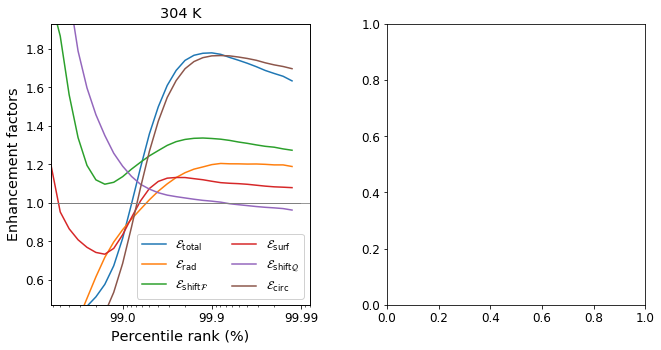

In [57]:

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(11,5))

## Plot enhancement factors at fixed SST
ax = axs[0]
SST = 304

ax.set_ylim((0.47,1.93))

x = np.flipud(1./(1-ranks[sQ]/100.))
addYLine(ax,x,y0=1,transformX=False)
# addZeroLine(ax,x,alpha=0)

for i_ef in range(n_ef):
    
    simname_0 = simname_patterns[ef_inds[i_ef][0]]%SST
    simname_1 = simname_patterns[ef_inds[i_ef][1]]%SST
#     lab = simtype_labels[ef_inds[i_ef][0]][:-1]+"/%s"%simtype_labels[ef_inds[i_ef][1]][1:]
    
    pr_ratio = np.nan*np.zeros((iQmax,))
    for iQ in range(iQmax):
        if perc_ILQ_pr[simname_1][iQ] != 0:
            pr_ratio[iQ] = perc_ILQ_pr[simname_0][iQ] / perc_ILQ_pr[simname_1][iQ]
    
    subplotRanksILog(ax,ranks[sQ],
                     pr_ratio,
#                      col=c[i],
#                      ltype=lt[i],
                     labels=ef_labels[i_ef],
                     transformX=False)

# transform x axis
transformXaxisIL(ax,x)
# reduce axis
iQ_min = 12
ax.set_xlim((x[iQ_min-1],0.8))

ax.set_title("%d K"%SST)
ax.set_xlabel('Percentile rank (%)')
ax.set_ylabel('Enhancement factors')
ax.legend(loc='lower right',ncol=2,framealpha=0.9,fontsize=12)

plt.savefig(os.path.join(figuredir,'enhancement_factors.pdf'),
                bbox_inches='tight')
plt.show()

### Enhancement factors, linear regression version

$$\mathcal{E}_{\text{surf}} = \frac{P_{\mathcal{O}_{\textrm{ref}}}}{P_{\mathcal{O}(F_{\mathcal{O}_{\textrm{ref}}})}} = e^{(\Delta a)T + \Delta b}$$

$$\delta \mathcal{E}_{\text{surf}} = \Delta a_{\textrm{surf}} 
= a_{\mathcal{O}_{\textrm{ref}}} - a_{\mathcal{O}(F_{\mathcal{O}_{\textrm{ref}}})}
= \delta P^Q_{\mathcal{O}_{\textrm{ref}}} - \delta P^Q_{\mathcal{O}(F_{\mathcal{O}_{\textrm{ref}}})}$$

In [14]:
print("Compute dataframe of enhancement factors")

def enhancementFactor(d_slope,d_intercept,SST):
    
    """The arguments are the regression coefficients of regression of precipitation intensities"""
    
    return np.exp(d_slope*SST + d_intercept)
    
n_Q = iQmax
    
##-- initialize
# enhancement factors
mean_ef_percIL_array = np.nan*np.zeros((n_SSTs,n_ef))
mean_ef_camountIL_array = np.nan*np.zeros((n_SSTs,n_ef))
# fractional changes in enhancement factors (SST-independent) = Delta(slopes)
mean_fracchange_percIL_ef = np.nan*np.zeros((n_ef,n_Q))
mean_fracchange_camountIL_ef = np.nan*np.zeros((n_ef,n_Q))
# changes in intercepts
mean_d_intercept_percIL_ef = np.nan*np.zeros((n_ef,n_Q))
mean_d_intercept_camountIL_ef = np.nan*np.zeros((n_ef,n_Q))

# compute
for i_ef in range(n_ef):

    # pick corresponding simulations
    simtype_0 = simtypes[ef_inds[i_ef][0]]
    simtype_1 = simtypes[ef_inds[i_ef][1]]

    # calculate differences in slopes
    mean_fracchange_percIL_ef[i_ef] = fracchange_mean_percIL[simtype_0] - fracchange_mean_percIL[simtype_1]
    mean_fracchange_camountIL_ef[i_ef] = fracchange_mean_camountIL[simtype_0] - fracchange_mean_camountIL[simtype_1]
    
    # calculate differences in intercepts
    mean_d_intercept_percIL_ef[i_ef] = offset_percIL[simtype_0] - offset_percIL[simtype_1]
    mean_d_intercept_camountIL_ef[i_ef] = offset_camountIL[simtype_0] - offset_camountIL[simtype_1]
    
    # calculate Q-dependent enhancement factors
    for i_SST in range(n_SSTs):

        SST = SSTs[i_SST]
        mean_ef_percIL_array[i_SST,i_ef] = np.nanmean(enhancementFactor(mean_fracchange_percIL_ef[i_ef],mean_d_intercept_percIL_ef[i_ef],SST)[sQext])
        mean_ef_camountIL_array[i_SST,i_ef] = np.nanmean(enhancementFactor(mean_fracchange_camountIL_ef[i_ef],mean_d_intercept_camountIL_ef[i_ef],SST)[sQext])

# Convert array to dataframe
mean_ef_percIL_df = pd.DataFrame(mean_ef_percIL_array)
mean_ef_camountIL_df = pd.DataFrame(mean_ef_camountIL_array)

labs = 'percentiles', 'amounts'
for df,lab in zip((mean_ef_percIL_df,mean_ef_camountIL_df),labs):
    
    print()
    print("- linearly-regressed enhancement factors in extreme",lab)
    
    # Remove simulations to avoid
    for i_SST,i_ef in SST_ef_2exclude:
        df.loc[i_SST,i_ef] = '-'

    # Replace row names
    row_names = dict(zip(range(n_SSTs),tuple(["%d K"%SST for SST in SSTs])))
    df = df.rename(row_names,axis='index')

    # Display in latex table format
    print(df.to_latex(float_format=lambda x:"%.2f"%x))

Compute dataframe of enhancement factors

- linearly-regressed enhancement factors in extreme percentiles
\begin{tabular}{lrlllrr}
\toprule
{} &    0 &    1 &    2 &    3 &    4 &    5 \\
\midrule
300 K & 1.46 &    - &    - &    - & 0.95 & 1.54 \\
302 K & 1.54 &    - &    - & 1.04 & 0.97 & 1.59 \\
304 K & 1.62 & 1.28 & 1.21 & 1.04 & 0.98 & 1.64 \\
306 K & 1.70 & 1.30 & 1.25 & 1.05 & 1.00 & 1.70 \\
308 K & 1.79 & 1.32 & 1.29 & 1.05 & 1.02 & 1.75 \\
\bottomrule
\end{tabular}


- linearly-regressed enhancement factors in extreme amounts
\begin{tabular}{lrlllrr}
\toprule
{} &    0 &    1 &    2 &    3 &    4 &    5 \\
\midrule
300 K & 1.46 &    - &    - &    - & 0.94 & 1.55 \\
302 K & 1.54 &    - &    - & 1.07 & 0.95 & 1.61 \\
304 K & 1.62 & 1.30 & 1.14 & 1.09 & 0.96 & 1.68 \\
306 K & 1.71 & 1.25 & 1.22 & 1.12 & 0.98 & 1.75 \\
308 K & 1.81 & 1.21 & 1.30 & 1.15 & 0.99 & 1.83 \\
\bottomrule
\end{tabular}



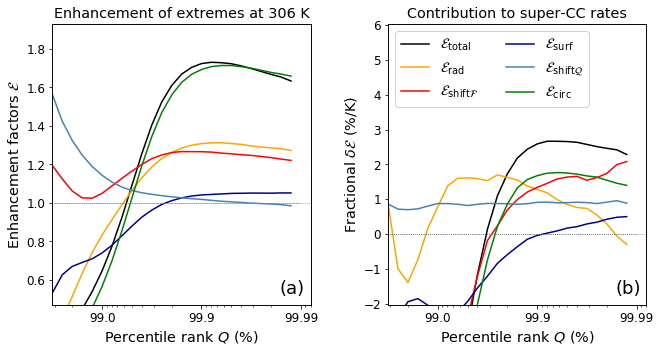

In [17]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(11,5))

##-- Panel (a): Plot enhancement factors at fixed SST
ax = axs[0]
SST = 306

ax.set_ylim((0.47,1.93))

x = np.flipud(1./(1-ranks[sQ]/100.))
addYLine(ax,x,y0=1,lt=':',transformX=False)
# addZeroLine(ax,x,alpha=0)

for i_ef in range(n_ef):
    
#     lab = simtype_labels[ef_inds[i_ef][0]][:-1]+"/%s"%simtype_labels[ef_inds[i_ef][1]][1:]
    
    efs = enhancementFactor(mean_fracchange_percIL_ef[i_ef],mean_d_intercept_percIL_ef[i_ef],SST)
    
    subplotRanksILog(ax,ranks[sQ],
                     efs[sQ],
                     col=ef_cols[i_ef],
#                      ltype=lt[i],
                     labels=ef_labels[i_ef],
                     transformX=False)


##-- Panel (b): Plot fractional change in enhancement factors (SST-independent)
ax = axs[1]
ax.set_ylim((-2.03,6.03))

x = np.flipud(1./(1-ranks[sQ]/100.))
addYLine(ax,x,y0=0,lt=':',transformX=False)

for i_ef in range(n_ef):
    
#     lab = simtype_labels[ef_inds[i_ef][0]][:-1]+"/%s"%simtype_labels[ef_inds[i_ef][1]][1:]
    
    subplotRanksILog(ax,ranks[sQ],
                     mean_fracchange_percIL_ef[i_ef][sQ]*100,
                     col=ef_cols[i_ef],
#                      ltype=lt[i],
                     labels=ef_labels[i_ef],
                     transformX=False)

    
for ax in axs:
    # transform x axis
    transformXaxisIL(ax,x)
    # reduce axis
    iQ_min = 15
    ax.set_xlim((x[iQ_min-1],0.8))

    ax.set_xlabel('Percentile rank $Q$ (%)')

axs[0].set_title("Enhancement of extremes at %d K"%SST)
axs[1].set_title("Contribution to super-CC rates")
    
axs[0].set_ylabel(r'Enhancement factors $\mathcal{E}$')
axs[1].set_ylabel(r'Fractional $\delta \mathcal{E}$ (%/K)')
ax.legend(loc='upper left',ncol=2,framealpha=0.9,fontsize=14)

##-- panel numbers
axs[0].text(0.88,0.04,'(a)',transform = axs[0].transAxes,fontsize=18)
axs[1].text(0.88,0.04,'(b)',transform = axs[1].transAxes,fontsize=18)

plt.savefig(os.path.join(figuredir,'mean_enhancement_factors.pdf'),
                bbox_inches='tight')
plt.show()

## Contributions (old)




$\mathcal{O}_{ref}$
$\mathcal{D}(Q_{\mathcal{O}_{ref}})$
$\mathcal{D}_{ref}$
$\mathcal{O}_{ref}$
$\mathcal{O}(F_{\mathcal{O}_{ref}})$
$\mathcal{D}(Q_{\mathcal{O}_{ref}})$
$\mathcal{D}_{ref}$
$\mathcal{O}_{ref}$
$\mathcal{O}(F_{\mathcal{O}_{ref}})$
$\mathcal{D}(Q_{\mathcal{O}_{ref}})$
$\mathcal{D}_{ref}$


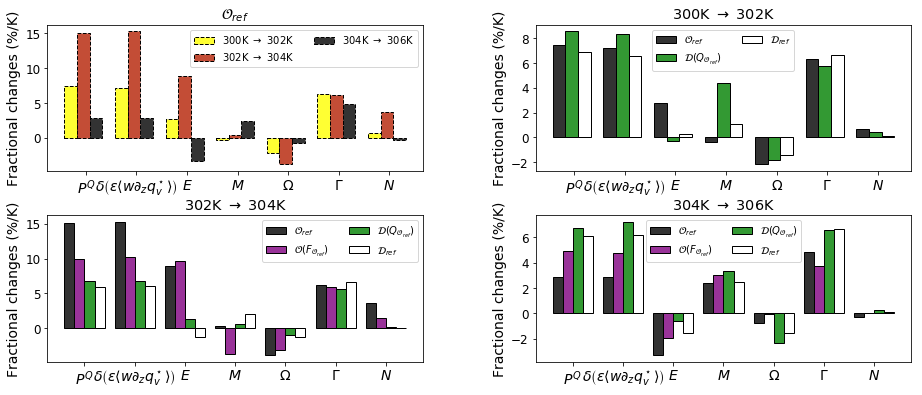

In [60]:
# contributions2plot = 'prQ','scaling','alpha','mass flux','w profile','thermodynamic','pressure','residual'
contributions2plot = 'prQ','scaling','alpha','mass flux','w profile','thermodynamic','residual'
# xlabels = r'$P^Q$','scaling',r'$\varepsilon$','mass\nflux'+r'$\langle w\rangle$',r'$w$'+'\nprofile',r'$q_v^\star$',r'$p$','NL-residual'
xlabels = r'$P^Q$',r'$\delta \left(\varepsilon\langle w\partial_z q_v^\star\rangle\right)$',r'$E$',r'$M$',r'$\Omega$',r'$\Gamma$','$N$'

font = {'family': 'sans-serif'}

# Start figure
# fig,axs = plt.subplots(ncols=1,nrows=2,figsize=(8,6))
fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(16,6))


#### (a) Plot bar plot with contributions in the organized case, for various base SSTs

ax = axs.flatten()[0]

i_sim = 0 # aggregated state
simname_pattern = simname_patterns[i_sim]
SSTs2plot = 300,302,304
dSST = 2 # K

cmap = plt.cm.gnuplot_r
SSTmin = np.min(SSTs2plot)
SSTmax = np.max(SSTs2plot)
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

N = len(SSTs2plot)

# width of the bars
barWidth = 1/(N+1)
# The x position of bars
r1 = np.arange(len(contributions2plot))
# r2 = [x + barWidth for x in r1]
r = [[x + i*barWidth for x in r1] for i in range(N)]

fc_dict = frac_change_fullDec_ILQ_pr

all_contributions = {}

for i_SST in range(N):
    
    SST = SSTs2plot[i_SST]
    
    key = "%s_%s"%(simname_pattern%SST,simname_pattern%(SST+dSST))
#     keylabel = r"%s"%simtype_labels[i_sim][:-1]+r", %dK \rightarrow$ %dK"%(SST,SST+dSST)
    keylabel = r"%dK $\rightarrow$ %dK"%(SST,SST+dSST)
    title = r"%s"%simtype_labels[i_sim]

#     print(keylabel)
    
    all_contributions[key] = []
    for contribution in contributions2plot:
        
        if fc_dict[key][contribution].__class__ == np.float64:
            all_contributions[key].append(fc_dict[key][contribution])
#             print('%s : %2.2f'%(contribution,fc_dict[key][contribution]))
        else:
            all_contributions[key].append(np.mean(fc_dict[key][contribution][sQext]))
#             print('%s : %2.2f'%(contribution,np.mean(fc_dict[key][contribution][sQext])))

    alpha = 0.8
    color = np.array(SST_col[i_SST]).copy()
    color[-1] = alpha
    
    ax.bar(r[i_SST],all_contributions[key],width = barWidth,linestyle=simtype_linetype[i_sim],
           edgecolor = 'k',color = color,label = keylabel)
    ax.set_title(title)
    print()
    
    
# plt.xticks([x + (N-1)/2*barWidth for x in range(len(xlabels))], xlabels,fontsize=14)
# ax.legend(loc='best',ncol=2,fontsize=10)
# ax.set_ylabel('Fractional changes (%/K)',fontsize=14)



#### (b) Plot bar plot with contributions in the organized case, for various base SSTs

simtype_col = 'k','purple','blue','green','white'

for i in range(1,4):
    
    ax = axs.flatten()[i]
    i_SST = i - 1

    SST = SSTs[i_SST]
    dSST = 2 # K

    sims2plot = list(range(5))
    for (i_SST_2ex,i_sim_2ex) in sims2exclude:
        if i_SST == i_SST_2ex:
            sims2plot.remove(i_sim_2ex)

    N = len(sims2plot)

    # width of the bars
    barWidth = 1/(N+1)
    # The x position of bars
    r1 = np.arange(len(contributions2plot))
    # r2 = [x + barWidth for x in r1]
    r = [[x + i*barWidth for x in r1] for i in range(N)]

    fc_dict = frac_change_fullDec_ILQ_pr

    all_contributions = {}

    for i_plot in range(N):
        
        i_sim = sims2plot[i_plot]

        simname_pattern = simname_patterns[i_sim]

        key = "%s_%s"%(simname_pattern%SST,simname_pattern%(SST+dSST))
    #     keylabel = r"%s"%simtype_labels[i_sim][:-1]+r", %dK \rightarrow$ %dK"%(SST,SST+dSST)
        keylabel = r"%s"%simtype_labels[i_sim]
        title = r"%dK $\rightarrow$ %dK"%(SST,SST+dSST)
    #     keylabel = ''

        print(keylabel)

        all_contributions[key] = []
        for contribution in contributions2plot:

            if fc_dict[key][contribution].__class__ == np.float64:
                all_contributions[key].append(fc_dict[key][contribution])
#                 print('%s : %2.2f'%(contribution,fc_dict[key][contribution]))
            else:
                all_contributions[key].append(np.mean(fc_dict[key][contribution][sQext]))
#                 print('%s : %2.2f'%(contribution,np.mean(fc_dict[key][contribution][sQext])))

        if np.any(np.isnan(all_contributions[key])):
            continue

        alpha = 0.8
        color = np.array(colors.to_rgba(simtype_col[i_sim]))
        color[-1] = alpha

        ax.bar(r[i_plot],all_contributions[key],width = barWidth,linestyle='-',
               edgecolor = 'k',color = color,label = keylabel)
        ax.set_title(title)

#         print()


    # plt.xticks([x + (N-1)/2*barWidth for x in range(len(xlabels))], xlabels,fontdict=font,fontsize=14)

for ax in axs.flatten():
    ax.set_xticks([x + (N-1)/2*barWidth for x in range(len(xlabels))])
    ax.set_xticklabels(xlabels,fontdict=font,fontsize=14)
#     if ax == axs[-1]:
#         ax.set_xticklabels(xlabels,fontdict=font,fontsize=14)
#     else:
#         ax.set_xticklabels([])
    ax.legend(loc='best',ncol=2,fontsize=10)
    ax.set_ylabel('Fractional changes (%/K)',fontsize=14)


plt.savefig(os.path.join(figuredir,'barplots.pdf'),
            bbox_inches='tight',transparent = True)
plt.show()

## Supplementary table of changes in mean and extreme rainfall and contributions

In [13]:
print("Compile contributions to all fractional changes")

contributions2plot = 'prQ','alpha','mass flux','w profile','thermodynamic','residual'
simtype4latex = '\hline \simOref{}',\
                '\hline \simFO{}',\
                '\hline \simFD{}',\
                '\hline \simQO{}',\
                '\hline \simDref{}'

n_cont = len(contributions2plot)
SST_pairs = (0,1),(1,2),(2,3),(3,4)
n_SSTpairs = len(SST_pairs)

# Row names for table
row_name_0 = np.chararray((n_SSTpairs*n_sims,),itemsize=30)
row_name_1 = np.chararray((n_SSTpairs*n_sims,),itemsize=25)

# Dictionary to read from
fc_dict = frac_change_fullDec_ILQ_pr
# initialize
fc_contrib_array = np.nan*np.zeros((n_SSTpairs*n_sims,n_cont+4))
# compute
i = 0 # row index in final table
for i_sim in range(n_sims):
    for i_SSTp in range(n_SSTpairs):
    
        i_SST0 = SST_pairs[i_SSTp][0]
        i_SST1 = SST_pairs[i_SSTp][1]
        SST0,SST1 = SSTs[i_SST0],SSTs[i_SST1]
        dSST = SST1-SST0
        
        # Corresponding experiment key
        simname_pattern = simname_patterns[i_sim]
        simname_cold = simname_pattern%SST0
        simname_warm = simname_pattern%SST1
        key = "%s_%s"%(simname_cold,simname_warm)
        
#         if (i_SST0,i_sim) in sims2exclude:
#             print('passing %s'%key)
#             continue
            
        # Update row names
        row_name_0[i] = simtype4latex[i_sim]
#         row_name_1[i] = "%d K - %d K"%(SST0,SST1)
        row_name_1[i] = "%d $\\rightarrow$ %d"%(SST0,SST1)
    
        
        prExcIL_cold = pr_mean[simname_cold]*cdf_invlog_ILQ_pr[simname_cold]
        prExcIL_warm = pr_mean[simname_warm]*cdf_invlog_ILQ_pr[simname_warm]
        
        # Mean precipitation change
        j = 2
        if (i_SST0,i_sim) not in sims2exclude:
            fc_contrib_array[i,j] = (prExcIL_warm[0]/prExcIL_cold[0] - 1)/dSST*100
        
        # Change in exceedance amount 99.9
        j = 3
        if (i_SST0,i_sim) not in sims2exclude:
            fc_contrib_array[i,j] = (prExcIL_warm[iQref]/prExcIL_cold[iQref] - 1)/dSST*100

        # Change in percentiles and contributions
        for j_cont in range(n_cont):
            j = j_cont+4
            contribution = contributions2plot[j_cont]
            
            if key not in fc_dict.keys():
                continue
            
            if fc_dict[key][contribution].__class__ == np.float64:
                cont_val = fc_dict[key][contribution]
            else:
                cont_val = np.mean(fc_dict[key][contribution][sQext])
            
            if (i_SST0,i_sim) not in sims2exclude:
                fc_contrib_array[i,j] = cont_val
        
        # Increment row index
        i += 1

print('last index:',i)

Compile contributions to all fractional changes
last index: 20


In [15]:
print("Generate latex table with fractional changes and contributions")


# Convert array to dataframe
fc_contrib_df = pd.DataFrame(fc_contrib_array)

# Replace column names
col_names = ('sim','SSTs','Pmean','Pexc999',)+contributions2plot
col_names = dict(zip(range(len(col_names)),col_names))
fc_contrib_df.rename(col_names,axis='columns',inplace=True)

# Drop last (empty) lines
fc_contrib_df.drop(list(range(i,len(row_name_0))),inplace=True)

# Implement multirow manually
row_name_current = row_name_0[0]
for j in range(1,len(row_name_0)):
    if row_name_0[j] == row_name_current:
        row_name_0[j] = ''
    else:
        row_name_current = row_name_0[j]
fc_contrib_df['sim'] = row_name_0[:i]
fc_contrib_df['SSTs'] = row_name_1[:i]

# Convert dataframe to latex table format
str_format = lambda s: s.decode('utf-8') 
float_format = lambda x:"%.2f"%x
formatters = [str_format]*2+[float_format]*(n_cont+2)
fc_contrib_str = fc_contrib_df.to_latex(formatters=formatters,multirow=True,escape=False,index=False,na_rep='-')
# Remove Nans
fc_contrib_str = fc_contrib_str.replace('nan','-')
# Show
print(fc_contrib_str)

Generate latex table with fractional changes and contributions
\begin{tabular}{llrrrrrrrr}
\toprule
               sim &                   SSTs & Pmean & Pexc999 &   prQ & alpha & mass flux & w profile & thermodynamic & residual \\
\midrule
 \hline \simOref{} &  300 $\rightarrow$ 302 &  3.63 &    7.45 &  7.44 &  2.76 &     -0.36 &     -2.20 &          6.32 &     0.66 \\
                   &  302 $\rightarrow$ 304 &  6.80 &   12.77 & 15.04 &  8.88 &      0.36 &     -3.83 &          6.18 &     3.70 \\
                   &  304 $\rightarrow$ 306 & -0.63 &    7.76 &  2.90 & -3.26 &      2.41 &     -0.77 &          4.81 &    -0.30 \\
                   &  306 $\rightarrow$ 308 &  6.61 &   11.15 & 10.83 & -4.92 &      7.44 &     -1.68 &          8.99 &     0.49 \\
   \hline \simFO{} &  300 $\rightarrow$ 302 &   - &     - &   - &   - &       - &       - &           - &      - \\
                   &  302 $\rightarrow$ 304 &  6.94 &   14.19 &  9.97 &  9.64 &     -3.70 &     -3.09 &          5.

# The role of precipitation efficiency

In [13]:
from scipy.optimize import curve_fit

print("Define functions to re-derive precipitation efficiency")

def computePE(perc_ILQ_pr,pr_sc):

    x = pr_sc[sQext]
    y = perc_ILQ_pr[sQext]/86400
    f = lambda x,alpha: alpha*x

    return curve_fit(f,x,y,p0=1)

def computePrecipitationEfficiencyFromSimname(simname):
    
    pres = p_profile[simname]*101.3 # Pa
    
    prFT_prQ = np.nan*np.zeros(ranks_ref.shape)

    for rank in ranks_ref[sQext]:

        irank_target = indexOfRank(rank,ranks_ref)
#             irank_ref = indexOfRank(rank,ranks_ref[sQext])

        w_prof = prQ_prof_conditionals[simname]['W'][irank_target]
        tabs_prof = prQ_prof_conditionals[simname]['TABS'][irank_target]
        qv_prof = prQ_prof_conditionals[simname]['QV'][irank_target]
        qvstar_prof = saturationSpecificHumidity(tabs_prof,pres)
        relhum_prof = qv_prof/qvstar_prof
        
        prFT_prQ[irank_target] = -scalingOGS09_zcoord(w_prof,tabs_prof,pres,z_coord.data,temp_type='adiabat',\
                                                      spechum=qv_prof,relhum=relhum_prof,levdim=0)

    # Calculate precipitation efficiency
    eps, ecov = computePE(perc_ILQ_pr[simname],prFT_prQ)

#     print(ecov[0][0]/eps[0])
    
    return eps[0]

Define functions to re-derive precipitation efficiency


In [14]:
print("Recalculate precipitation efficiency")

eps_FT = {}
eps4table = np.nan*np.zeros((n_SSTs,n_sims))
    
for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
        
        simname = simname_patterns[i_sim]%SST

        eps = computePrecipitationEfficiencyFromSimname(simname)

        if eps == 1.0:
            print("epsilon not found for %s"%simname)
        epsFT[simname] = eps
        eps4table[i_SST,i_sim] = eps
        


Recalculate precipitation efficiency


/global/homes/b/bfildier/anaconda3/envs/pyPhD/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


epsilon not found for RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg


In [15]:
print("Convert precipitation efficiency to dataframe and export as LaTeX table")
print()

# Convert array to dataframe
eps_df = pd.DataFrame(eps4table)

# Remove simulations to avoid
for i_SST,i_sim in sims2exclude:
    eps_df.loc[i_SST,i_sim] = '-'

# Replace row names
row_names = dict(zip(range(n_SSTs),tuple(["%d K"%SST for SST in SSTs])))
eps_df = eps_df.rename(row_names,axis='index')

# Display in latex table format
print(eps_df.to_latex(float_format=lambda x:"%.3f"%x))

Convert precipitation efficiency to dataframe and export as LaTeX table

\begin{tabular}{lrllrr}
\toprule
{} &     0 &     1 &     2 &     3 &     4 \\
\midrule
300 K & 0.576 &     - &     - & 0.374 & 0.373 \\
302 K & 0.662 & 0.661 &     - & 0.391 & 0.387 \\
304 K & 1.015 & 0.946 &     - & 0.410 & 0.393 \\
306 K & 0.954 & 0.939 & 0.678 & 0.428 & 0.402 \\
308 K & 1.046 & 1.026 & 0.798 & 0.430 & 0.401 \\
\bottomrule
\end{tabular}



Compute, for all SSTs and all simmulation types:
- precipitation efficiency $\varepsilon$
- relatice humidity $\langle RH \rangle$
- saturation decifit $\langle 1 - RH \rangle$
- effective vertical velocity $\langle w \rangle$
- thermodynamic factor in z-coordinates $\langle w \partial_z q_v^\star\rangle$
- thermodynamic factor in p-coordinates $\langle w \partial_p q_v^\star\rangle$
- effective extreme precipitation intensity $\mathbb{E}\left(P^Q\vert Q \in [0.999,0.9999]\right)$

In [16]:
print("compute values for correlations for precipitation efficiency argument")

# Manual definition of the tropopause
i_trop = 44 # approximate tropopause
s_trop = slice(0,44) # approximate troposphere

# Store values
intRH_array = np.nan*np.zeros((n_SSTs,n_sims))
satDef_array = np.nan*np.zeros((n_SSTs,n_sims))
intW_array = np.nan*np.zeros((n_SSTs,n_sims))
intMuGamma_array = np.nan*np.zeros((n_SSTs,n_sims))
intMuGammaP_array = np.nan*np.zeros((n_SSTs,n_sims))
prQ_array = np.nan*np.zeros((n_SSTs,n_sims))
meanP_array = np.nan*np.zeros((n_SSTs,n_sims))
eps_array = np.nan*np.zeros((n_SSTs,n_sims))

###--- Fixed climate quantities

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
    
        simname = simname_patterns[i_sim]%SST
        
        # Get average profiles across extremes
        w_profiles = []
        tabs_profiles = []
        qv_profiles = []
        for iQ in range(iQref,iQmax):
            w_profiles.append(prQ_prof_conditionals[simname]['W'][iQ])
            tabs_profiles.append(prQ_prof_conditionals[simname]['TABS'][iQ])
            qv_profiles.append(prQ_prof_conditionals[simname]['QV'][iQ])
        p_meanprof = p_profile[simname]*101.3 # mbar to Pa
        w_meanprof = np.nanmean(np.vstack(w_profiles),axis=0)
        tabs_meanprof = np.nanmean(np.vstack(tabs_profiles),axis=0)
        qv_meanprof = np.nanmean(np.vstack(qv_profiles),axis=0)
        qvstar_meanprof = saturationSpecificHumidity(tabs_meanprof,p_meanprof)
        relhum_meanprof = qv_meanprof/qvstar_meanprof
        tad_meanprof = moistAdiabatSimple(tabs_meanprof[0],p_meanprof,spechum=qv_meanprof,relhum=relhum_meanprof,levdim=0)
        
        # Crop profiles in troposphere
        pres, tabs, tad, w, qv, z = cropProfiles(p_meanprof, # Pa
                                                     tabs_meanprof,
                                                     [tad_meanprof,
                                                      w_meanprof,
                                                      qv_meanprof/1000, # kg/kg
                                                      z_coord.data],
                                                     levdim=0)
        
#         qv = prQ_prof_conditionals[simname]['QV'][iQref][s_trop]/1000 # kg/kg
#         pres = p_profile[simname][s_trop]*101.3 # Pa
#         z = z_coord[s_trop]
#         tabs = prQ_prof_conditionals[simname]['TABS'][iQref][s_trop]
#         w = prQ_prof_conditionals[simname]['W'][iQref][s_trop]

        ##---- calculation with prQ-conditioned temperature profile
#         temp = tabs
        ##---- calculation with prQ-conditioned adiabatic temperature profile
        temp = tad
    
        qvstar = saturationSpecificHumidity(temp,pres)
        qvstar_tabs = saturationSpecificHumidity(tabs,pres)
        gamma = np.diff(qvstar)/np.diff(z)
        gammaP = np.diff(qvstar)/np.diff(pres)
        relhum = qv/qvstar_tabs*100
        
        # pressure-weighted vertical integral of RH
        intRH = verticalPressureIntegral(pres,relhum)/verticalPressureIntegral(pres)
        intRH_array[i_SST,i_sim] = intRH
        satDef_array[i_SST,i_sim] = 1-intRH/100
        # pressure-weighted vertical integral of W
#         intW = -verticalPressureIntegral(pres,w)
        intW = verticalPressureIntegral(pres,w) / verticalPressureIntegral(pres)   
        intW_array[i_SST,i_sim] = intW
        # pressure-weighted vertical integral of mu*gamma
        intMuGamma = verticalPressureIntegral(pres,values=w,dvdp=gamma)/intW
        intMuGamma_array[i_SST,i_sim] = intMuGamma
        # pressure-weighted vertical integral of mu*gammaP
        intMuGammaP = verticalPressureIntegral(pres,values=w,dvdp=gammaP)/intW
        intMuGammaP_array[i_SST,i_sim] = intMuGammaP
        # mean of extremes
        prQ = np.nanmean(perc_ILQ_pr[simname][sQext])
        prQ_array[i_SST,i_sim] = prQ
        # mean P
        meanP = pr_mean[simname]
        meanP_array[i_SST,i_sim] = meanP
        # precipitation efficiency
        eps = computePrecipitationEfficiencyFromSimname(simname)
        eps_array[i_SST,i_sim] = eps
        
###--- Fractional change quantities

# automate
def deltaFracChange(var_array):

    NSST, Nsims = var_array.shape

    fc_array = (var_array[1:,:]/var_array[:NSST-1,:] - 1)/2*100
    delta_fc_array = np.zeros((NSST-1,Nsims-1))
    for j in range(Nsims-1):
        delta_fc_array[:,j] = fc_array[:,j] - fc_array[:,-1]

    return delta_fc_array



# compute enhancement of each component in comparison with Dref
for key in 'eps_array','prQ_array','intRH_array','satDef_array','intW_array','intMuGamma_array','intMuGammaP_array':
    
    array = getattr(thismodule,key)
    NSST, Nsims = array.shape
    norm_array = np.nan*np.zeros((NSST,Nsims-1))
    for i_sim in range(Nsims-1):
        norm_array[:,i_sim] = array[:,i_sim]/array[:,-1]
    setattr(thismodule,"norm_%s"%key,norm_array)

# compute difference in fractional changes in each component with Dref
delta_E_array = deltaFracChange(eps_array)
delta_prQ_array = deltaFracChange(prQ_array)
delta_intRH_array = deltaFracChange(intRH_array)
delta_satDef_array = deltaFracChange(satDef_array)
delta_intW_array = deltaFracChange(intW_array)
delta_intMuGamma_array = deltaFracChange(intMuGamma_array)
delta_intMuGammaP_array = deltaFracChange(intMuGammaP_array)


compute values for correlations for precipitation efficiency argument


/global/homes/b/bfildier/anaconda3/envs/pyPhD/lib/python3.6/site-packages/ipykernel/__main__.py:36: RuntimeWarning: Mean of empty slice
/global/homes/b/bfildier/anaconda3/envs/pyPhD/lib/python3.6/site-packages/ipykernel/__main__.py:37: RuntimeWarning: Mean of empty slice
/global/homes/b/bfildier/anaconda3/envs/pyPhD/lib/python3.6/site-packages/ipykernel/__main__.py:38: RuntimeWarning: Mean of empty slice
/global/homes/b/bfildier/anaconda3/envs/pyPhD/lib/python3.6/site-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in double_scalars
/global/homes/b/bfildier/anaconda3/envs/pyPhD/lib/python3.6/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in double_scalars
/global/homes/b/bfildier/anaconda3/envs/pyPhD/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [16]:
print("Quickly show the contributions from eps, intW and intMuGamma to the change in precipitation extremes"+\
      "in the reference disorganized simulation Dref")
print()

sst_values = SSTs
i_sim = 4

for data_array in prQ_array, eps_array, intW_array, intMuGamma_array:

    data_values = data_array[:,i_sim]
    slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(data_values))
    
    print(slope*100, r_value)

Quickly show the contributions from eps, intW and intMuGamma to the change in precipitation extremesin the reference disorganized simulation Dref

5.58849680802 0.997719774919
0.792883720792 0.897931544215
1.50706672369 0.982147842498
3.40479350675 0.993019462883


In [32]:
print(">-- Compare relative mean rainfall differences between simulations Oref and Dref+4K ")
print()

i_sim_Oref = 0
i_sim_Dref = 4
di_SST_4K = 2

for i_SST in range(n_SSTs-di_SST_4K):
    
    reldiff_meanP = (meanP_array[i_SST,i_sim_Oref]/meanP_array[i_SST+di_SST_4K,i_sim_Dref] - 1)*100
    print("%dK: %2.2f %%"%(SSTs[i_SST],reldiff_meanP))

print()
print(">-- Enhancement of P^Q between simulations Oref and Dref+4K at 300K")
print()

i_SST_300K = 0
array = prQ_array
reldiff_prQ_Oref300 = (array[i_SST_300K,i_sim_Oref]/array[i_SST_300K,i_sim_Dref] - 1)*100

print("%dK: %2.2f %%"%(SSTs[i_SST_300K],reldiff_prQ_Oref300))

print()
print(">-- Enhancement of P^Q in simulation Dref between 300K and 304K")
print()

reldiff_prQ_Dref304 = (array[i_SST_300K+di_SST_4K,i_sim_Dref]/array[i_SST_300K,i_sim_Dref] - 1)*100

print("%dK: %2.2f %%"%(SSTs[i_SST_300K],reldiff_prQ_Dref304))

print()
print(">-- Difference between the two, circulation enhancement at 300K")
print()

print("%dK: %2.2f %%"%(SSTs[i_SST_300K],reldiff_prQ_Oref300-reldiff_prQ_Dref304))

print()
print(">-- Enhancement of fractional increase in P^Q between 300K and 302K by the circulation alone")
print()

fc_Oref_300_302 = (array[1,i_sim_Oref]/array[0,i_sim_Oref] - 1)/2*100
fc_Dref_304_306 = (array[3,i_sim_Dref]/array[2,i_sim_Dref] - 1)/2*100

print("%2.2f %%"%(fc_Oref_300_302 - fc_Dref_304_306))

print(">-- Enhancement of mean P by organization at all SSTs")
print()

i_sim_Oref = 0
i_sim_Dref = 4

for i_SST in range(n_SSTs):
    
    reldiff_meanP = (meanP_array[i_SST,i_sim_Oref]/meanP_array[i_SST,i_sim_Dref] - 1)*100
    print("%dK: %2.2f %%"%(SSTs[i_SST],reldiff_meanP))


>-- Compare relative mean rainfall differences between simulations Oref and Dref+4K 

300K: 0.10 %
302K: 0.20 %
304K: 6.75 %

>-- Enhancement of P^Q between simulations Oref and Dref+4K at 300K

300K: 46.71 %

>-- Enhancement of P^Q in simulation Dref between 300K and 304K

300K: 27.57 %

>-- Difference between the two, circulation enhancement at 300K

300K: 19.14 %

>-- Enhancement of fractional increase in P^Q between 300K and 302K by the circulation alone

1.35 %
>-- Enhancement of mean P by organization at all SSTs

300K: 14.80 %
302K: 15.42 %
304K: 21.98 %
306K: 12.39 %
308K: 19.33 %


In [18]:
print("Define functions to compute enhancement factors from SST-simtype array")

def computeEnhancementFactors(X_array):
    
    """X_arrray contains statistics in SST-simtype space"""

    # initialize
    ef_array = np.nan*np.zeros((n_SSTs,n_ef))
    # compute
    for i_SST in range(n_SSTs):

        SST = SSTs[i_SST]

        for i_ef in range(n_ef):

            # Pass SST-EF pair to exclude
            if (i_SST,i_ef) in SST_ef_2exclude:
                continue

            # get average over extremes
            ef_array[i_SST,i_ef] = X_array[i_SST,ef_inds[i_ef][0]] / X_array[i_SST,ef_inds[i_ef][1]]

    return ef_array
    
def printEFArrayAsLatexTable(array):
    # Convert array to dataframe
    ef_df = pd.DataFrame(array)

    # Remove simulations to avoid
    for i_SST,i_ef in SST_ef_2exclude:
        ef_df.loc[i_SST,i_ef] = '-'

    # Replace row names
    row_names = dict(zip(range(n_SSTs),tuple(["%d K"%SST for SST in SSTs])))
    ef_df = ef_df.rename(row_names,axis='index')

    # Display in latex table format
    print(ef_df.to_latex(float_format=lambda x:"%.2f"%x))

Define functions to compute enhancement factors from SST-simtype array


In [19]:
print("Compute enhancement factors in thermodynamic-dynamic decomposition + mean rain")

# compute enhancement of each component in comparison with Dref
for key in 'eps_array','prQ_array','intRH_array','satDef_array','intW_array','intMuGamma_array',\
    'intMuGammaP_array','meanP_array':
    
    array = getattr(thismodule,key)
    ef_array = computeEnhancementFactors(array)
    setattr(thismodule,"ef_%s"%key,ef_array)
    
    print()
    print('--------------- %s -----------------'%key)
    printEFArrayAsLatexTable(ef_array)


Compute enhancement factors in thermodynamic-dynamic decomposition + mean rain

--------------- eps_array -----------------
\begin{tabular}{lrlllrr}
\toprule
{} &    0 &    1 &    2 &    3 &    4 &    5 \\
\midrule
300 K & 1.55 &    - &    - &    - & 1.00 & 1.54 \\
302 K & 1.71 &    - &    - & 1.00 & 1.01 & 1.69 \\
304 K & 2.58 & 1.39 & 1.73 & 1.07 & 1.04 & 2.47 \\
306 K & 2.38 & 1.69 & 1.39 & 1.02 & 1.07 & 2.23 \\
308 K & 2.61 & 1.99 & 1.29 & 1.02 & 1.07 & 2.44 \\
\bottomrule
\end{tabular}


--------------- prQ_array -----------------
\begin{tabular}{lrlllrr}
\toprule
{} &    0 &    1 &    2 &    3 &    4 &    5 \\
\midrule
300 K & 1.47 &    - &    - &    - & 0.94 & 1.55 \\
302 K & 1.48 &    - &    - & 1.01 & 0.97 & 1.52 \\
304 K & 1.72 & 1.20 & 1.31 & 1.09 & 0.99 & 1.74 \\
306 K & 1.62 & 1.28 & 1.20 & 1.06 & 1.00 & 1.63 \\
308 K & 1.81 & 1.33 & 1.32 & 1.03 & 1.02 & 1.77 \\
\bottomrule
\end{tabular}


--------------- intRH_array -----------------
\begin{tabular}{lrlllrr}
\toprule
{} &

In [22]:
print("Compute the mean enhancement factors for mean precipitation at all SSTs")

for ef in np.nanmean(ef_meanP_array,axis=0):
    print('& %2.2f'%ef,end=' ')
print('\\\\')

Compute the mean enhancement factors for mean precipitation at all SSTs
& 1.17 & 0.99 & 1.19 & 1.00 & 1.11 & 1.05 \\


Show all pairs of correlations between epsilon, prQ and their fractional changes
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg


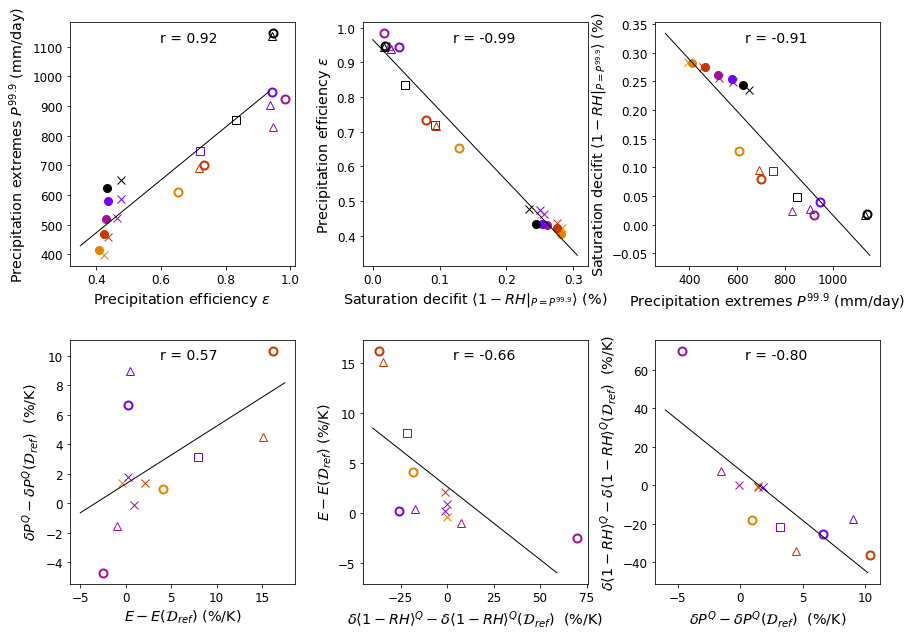

In [38]:
print("Show all pairs of correlations between epsilon, prQ and their fractional changes")

sims2hide = [(0,1),(0,2),(1,2),(2,2)]

# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 298.
SSTmax = 308.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]


# # Store values
# prQ_all = {}
# eps_all = {}
# intRH_all = {}

# var_arrays = [prQ_array,eps_array,intRH_array]
var_arrays = [prQ_array,eps_array,satDef_array]
var_labels = r"Precipitation extremes $P^{99.9}$ (mm/day)",\
             r"Precipitation efficiency $\varepsilon$",\
             r"Saturation decifit $\langle 1-RH\vert_{P = P^{99.9}}\rangle$ (%)"
#              r"Vertically-integrated $\langle RH\vert_{P = P^{99.9}}\rangle$ (%)"
# var_ranges = (380,1000),(0.03,0.07),(66,92)
var_ranges = (300,1250),(0.35,1.0),(0.,0.34)

# delta_var_arrays = [delta_prQ_array,delta_E_array,delta_intRH_array]
delta_var_arrays = [delta_prQ_array,delta_E_array,delta_satDef_array]
delta_var_labels = r'$\delta P^Q - \delta P^Q\left(\mathcal{D}_{ref}\right)$  (%/K)',\
                   r'$E-E\left(\mathcal{D}_{ref}\right)$ (%/K)',\
                   r'$\delta \langle 1-RH\rangle^Q - \delta \langle 1-RH\rangle^Q\left(\mathcal{D}_{ref}\right)$  (%/K)'
delta_var_ranges = (-6,12),(-5,20),(-40,70)

array_list = [var_arrays,delta_var_arrays]
labels_list = [var_labels,delta_var_labels]
xrange_list = [var_ranges,delta_var_ranges]

# Automate line fitting
def fitLine(axs,i_var,i_row):
    
    var1 = array_list[i_row][i_var]
    var2 = array_list[i_row][(i_var+1)%3]
    
    # take only subset of simulations
    x1 = []
    x2 = []
    for i in range(var1.shape[0]):
        for j in range(var1.shape[1]):
            if (i,j) not in sims2hide:
                x1.append(var1[i,j])
                x2.append(var2[i,j])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x2,x1)
    xmin,xmax = xrange_list[i_row][(i_var+1)%3]
    x = np.arange(xmin,xmax,(xmax-xmin)/10)
    y = intercept + slope*x
    
    ax = axs[i_row,i_var]
    ax.plot(x,y,c='k',linewidth=1)
    ax.text(0.4,0.92,'r = %.2f'%r_value,transform = ax.transAxes,fontsize=14)


fig, axs = plt.subplots(ncols=3,nrows=2,figsize=(15,10))

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
    
        simname = simname_patterns[i_sim]%SST
        
        if (i_SST,i_sim) in sims2hide:
            print("passing %s"%simname)
            continue
        
        # Marker options
        col = SST_col[i_SST]
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = col
        mw = 1
        if i_sim == 0:
            mw = 2
        
        # store for linear regression
        
        # plot
        for i_var in range(3):

            var1 = var_arrays[i_var][i_SST,i_sim]
            var2 = var_arrays[(i_var+1)%3][i_SST,i_sim]
            axs[0,i_var].plot(var2,var1,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=col,markeredgewidth=mw)

            if i_SST < n_SSTs-1 and i_sim < n_sims-1:
                dvar1 = delta_var_arrays[i_var][i_SST,i_sim]
                dvar2 = delta_var_arrays[(i_var+1)%3][i_SST,i_sim]
                axs[1,i_var].plot(dvar2,dvar1,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=col,markeredgewidth=mw)

for i_var in range(3):
    
    for i_row in range(2):
        
        axs[i_row,i_var].set_ylabel(labels_list[i_row][i_var])
        axs[i_row,i_var].set_xlabel(labels_list[i_row][(i_var+1)%3])
        fitLine(axs,i_var,i_row)

plt.savefig(os.path.join(figuredir,'all_correlations_P999_eps_satDef.pdf'),
                bbox_inches='tight')
plt.show()


passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg


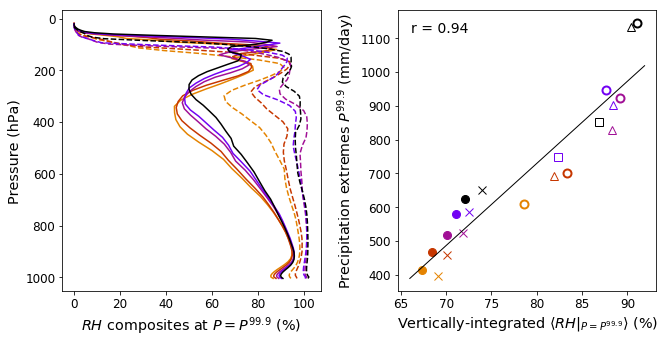

In [39]:

# sims2hide = [(0,1),(0,2),(1,2),(2,2),(1,3)]
sims2hide = [(0,1),(0,2),(1,2),(2,2)]

# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 298.
SSTmax = 308.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]

# Store values
intRH_all = []
intRH_array = np.nan*np.zeros((n_SSTs,n_sims))
prQ_all = []
prQ_array = np.nan*np.zeros((n_SSTs,n_sims))
eps_all = []

fig, axs = plt.subplots(ncols=2,figsize=(11,5))

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
    
        simname = simname_patterns[i_sim]%SST
        
        if (i_SST,i_sim) in sims2hide:
            print("passing %s"%simname)
            continue
        
        # Calculate relative humidity profile
        qv = prQ_prof_conditionals[simname]['QV'][iQref]/1000
        pres = p_profile[simname]*100
        tabs = prQ_prof_conditionals[simname]['TABS'][iQref]
        qvstar = saturationSpecificHumidity(tabs,pres)
        relhum = qv/qvstar*100
        
        # pressure-weighted vertical integral of RH
        intRH = verticalPressureIntegral(pres,relhum)/verticalPressureIntegral(pres)
        intRH_all.append(intRH)
        intRH_array[i_SST,i_sim] = intRH
        # mean extreme
        prQ = perc_ILQ_pr[simname][iQref]
        prQ_all.append(prQ)
        prQ_array[i_SST,i_sim] = prQ
        # precipitation efficiency
        eps = eps_df.iloc[i_SST,i_sim]
        eps_all.append(eps)

        col = SST_col[i_SST]
        # Show points
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = col
        mw = 1
        if i_sim == 0:
            mw = 2
            
        # Panel (a) - profiles of RH for reference runs
        ax = axs[0]
        if i_sim in (0,4):
            ax.plot(relhum,pres/100,c=col,linestyle=simtype_linetype[i_sim])
        
        # Panel (b) - Scatter 
        ax = axs[1]
#         ax.plot(intRH,eps,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=col,markeredgewidth=mw)
        ax.plot(intRH,prQ,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=col,markeredgewidth=mw)
        
        
axs[0].invert_yaxis()
axs[0].set_xlabel(r'$RH$ composites at $P = P^{99.9}$ (%)')
axs[0].set_ylabel(r'Pressure (hPa)')

axs[1].set_xlabel(r"Vertically-integrated $\langle RH\vert_{P = P^{99.9}}\rangle$ (%)")
# axs[1].set_ylabel(r"Precipitation efficiency $\varepsilon$")
axs[1].set_ylabel(r"Precipitation extremes $P^{99.9}$ (mm/day)")


# Linear fit panel (b)
ax = axs[1]
# slope, intercept, r_value, p_value, std_err = stats.linregress(intRH_all,eps_all)
slope, intercept, r_value, p_value, std_err = stats.linregress(intRH_all,prQ_all)
x = np.arange(66,92,0.1)
y = intercept + slope*x
ax.plot(x,y,c='k',linewidth=1)
ax.text(0.05,0.92,'r = %.2f'%r_value,transform = ax.transAxes,fontsize=14)

plt.savefig(os.path.join(figuredir,'RH_profiles_and_correlation_w_P999.pdf'),
                bbox_inches='tight')
plt.show()

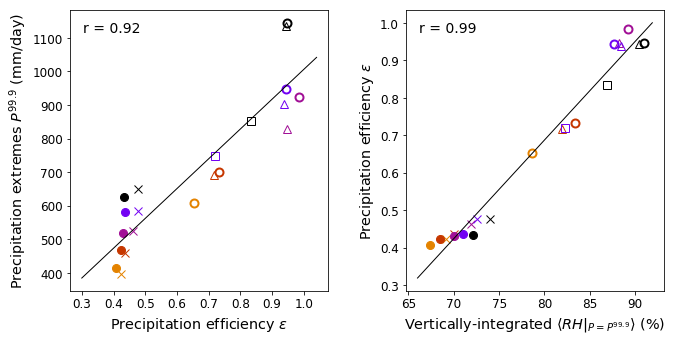

In [52]:
# coloring SSTs
cmap = plt.cm.gnuplot_r
SSTmin = 298.
SSTmax = 308.
SST_col = [cmap(i) for i in (SSTs-np.array(SSTmin))/(SSTmax-SSTmin)]


fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(11,5))

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
        
        col = SST_col[i_SST]
        # Show points
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = col
        mw = 1
        if i_sim == 0:
            mw = 2
        
        # pressure-weighted vertical integral of RH
        intRH = intRH_array[i_SST,i_sim]
        # mean extreme
        prQ = prQ_array[i_SST,i_sim]
        # precipitation efficiency
        eps = eps_df.iloc[i_SST,i_sim]
        
        # Panel (a)
        ax = axs[0]
        ax.plot(eps,prQ,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=col,markeredgewidth=mw)
        
        # Panel (b)
        ax = axs[1]
        ax.plot(intRH,eps,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=col,markeredgewidth=mw)
        


# panel (a)
axs[0].set_ylabel(r"Precipitation extremes $P^{99.9}$ (mm/day)")
axs[0].set_xlabel(r"Precipitation efficiency $\varepsilon$")
x_eps = np.arange(0.3,1.1,0.1)
axs[0].set_xticks(x_eps)
axs[0].set_xticklabels(x_eps)

# panel (b)
axs[1].set_ylabel(r"Precipitation efficiency $\varepsilon$")
axs[1].set_xlabel(r"Vertically-integrated $\langle RH\vert_{P = P^{99.9}}\rangle$ (%)")
axs[1].set_yticks(x_eps)
axs[1].set_yticklabels(x_eps)


# Linear fit panel (a)
ax = axs[0]
slope, intercept, r_value, p_value, std_err = stats.linregress(eps_all,prQ_all)
x = np.arange(0.3,1.05,0.01)
y = intercept + slope*x
ax.plot(x,y,c='k',linewidth=1)
ax.text(0.05,0.92,'r = %.2f'%r_value,transform = ax.transAxes,fontsize=14)

# Linear fit panel (b)
ax = axs[1]
slope, intercept, r_value, p_value, std_err = stats.linregress(intRH_all,eps_all)
x = np.arange(66,92,0.1)
y = intercept + slope*x
ax.plot(x,y,c='k',linewidth=1)
ax.text(0.05,0.92,'r = %.2f'%r_value,transform = ax.transAxes,fontsize=14)

plt.savefig(os.path.join(figuredir,'correlations_P999_eps_and_eps_intRH.pdf'),
                bbox_inches='tight')
plt.show()

passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg


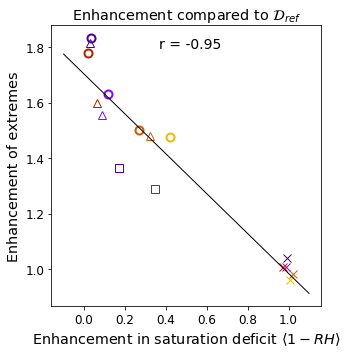

In [54]:



# Store values
# intRH_all = []
# prQ_all = []
# eps_all = []
# satDef_all = []
x_all = []
y_all = []

fig, ax = plt.subplots(ncols=1,figsize=(5,5))

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims-1):
    
        simname = simname_patterns[i_sim]%SST
        
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        
        
#         x = norm_intRH_array[i_SST,i_sim]
#         x = norm_intW_array[i_SST,i_sim]
        x = norm_satDef_array[i_SST,i_sim]
        y = norm_prQ_array[i_SST,i_sim]
        x_all.append(x)
        y_all.append(y)

#         intRH_all.append(norm_intRH_array[i_SST,i_sim])
#         satDef_all.append(norm_satDef_array[i_SST,i_sim])
#         prQ_all.append(norm_prQ_array[i_SST,i_sim])
#         eps_all.append(norm_eps_array[i_SST,i_sim])

        col = SST_col[i_SST]
        # Show points
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = col
        mw = 1
        if i_sim == 0:
            mw = 2

        ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=col,markeredgewidth=mw)
        
        
# axs[1].set_xlabel(r"Vertically-integrated $\langle RH\vert_{P = P^{99.9}}\rangle$ (%)")
# # axs[1].set_ylabel(r"Precipitation efficiency $\varepsilon$")
# axs[1].set_ylabel(r"Precipitation extremes $P^{99.9}$ (mm/day)")


# slope, intercept, r_value, p_value, std_err = stats.linregress(intRH_all,eps_all)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_all,y_all)
x = np.arange(-0.1,1.2,0.1)
y = intercept + slope*x
ax.plot(x,y,c='k',linewidth=1)
ax.text(0.4,0.92,'r = %.2f'%r_value,transform = ax.transAxes,fontsize=14)

ax.set_xlabel(r'Enhancement in saturation deficit $\langle 1-RH \rangle$')
ax.set_ylabel(r'Enhancement of extremes')
ax.set_title(r'Enhancement compared to $\mathcal{D}_{ref}$')

plt.savefig(os.path.join(figuredir,'enhancement_prQ_vs_enhancement_satdef_from_Dref.pdf'),
                bbox_inches='tight')
plt.show()

Show correlation between enhancement factors and enhancement in precipitation efficiency
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1-b100-radagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1-b100-radagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1-b100-radagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r1-b100-radagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r1-b100-radagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1-b100-radagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1-b100-radagg


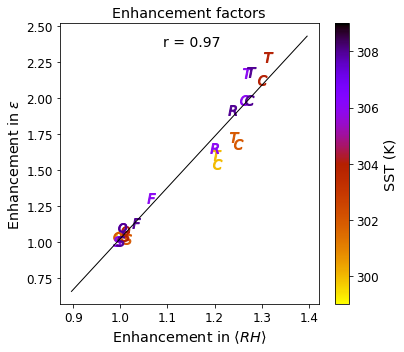

In [34]:
print("Show correlation between enhancement factors and enhancement in precipitation efficiency")

# ef_markers = r"$t$",r"$r$",r"$F$",r"$s$",r"$Q$",r"$c$"
ef_markers = "T","R","F","S","Q","C"
# ef_markers = [matplotlib.markers['.']]*6

predictors = ef_eps_array, ef_intRH_array, ef_satDef_array, ef_intW_array, ef_intMuGamma_array, ef_prQ_array
predictors_labels = r'$\varepsilon$', r'$\langle RH \rangle$', r'$\langle 1-RH \rangle$',\
    r'$\langle W \rangle$', r'$\langle \mu\gamma \rangle$', r'$P^Q$'
predictors_names = 'eps','intRH','satDef','intW','intMuGamma','prQ'

# eps vs RH
i_pred_x = 1
i_pred_y = 0

# prQ vs eps
# i_pred_x = 0
# i_pred_y = 5

# Store values
x_all = []
y_all = []

fig, ax = plt.subplots(ncols=1,figsize=(6,5))

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_ef in range(n_ef):
    
        simname = simname_patterns[i_sim]%SST
        
#         print(simname)
        if (i_SST,ef_inds[i_ef][0]) in sims2exclude or (i_SST,ef_inds[i_ef][1]) in sims2exclude:
            print("passing %s"%simname)
#             print(' passing')
            continue
        
        
        x = predictors[i_pred_x][i_SST,i_ef]
        y = predictors[i_pred_y][i_SST,i_ef]
        x_all.append(x)
        y_all.append(y)

        col = SST_col[i_SST]
        # Show points
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = col
        mw = 1
        if i_sim == 0:
            mw = 2

#         ax.plot(x,y,ef_markers[i_ef], ms=8, markerfacecolor=mfc,markeredgecolor=col,markeredgewidth=mw)
        ax.scatter(x,y,marker="$ {} $".format(ef_markers[i_ef]), c=col,s=100)


# compute range of values to plot for regression line
fac = 0.3
x_range = np.min(x_all),np.max(x_all)
dxrange = x_range[1] - x_range[0]
x_range2plot = x_range[0]-fac*dxrange, x_range[1]+fac*dxrange

# slope, intercept, r_value, p_value, std_err = stats.linregress(intRH_all,eps_all)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_all,y_all)
x = np.arange(x_range2plot[0],x_range2plot[1],0.1)
y = intercept + slope*x
ax.plot(x,y,c='k',linewidth=1)
ax.text(0.4,0.92,'r = %.2f'%r_value,transform = ax.transAxes,fontsize=14)


# Color bar
cax, _ = matplotlib.colorbar.make_axes(ax)
normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,label='SST (K)')

# ax.set_xlabel(r'Enhancement in saturation deficit $\langle 1-RH \rangle$')
ax.set_xlabel(r'Enhancement in %s'%(predictors_labels[i_pred_x]))
ax.set_ylabel(r'Enhancement in %s'%(predictors_labels[i_pred_y]))
ax.set_title(r'Enhancement factors')

plt.savefig(os.path.join(figuredir,'enhancement_%s_vs_enhancement_%s.pdf'%(predictors_names[i_pred_y],predictors_names[i_pred_x])),
                bbox_inches='tight')
plt.show()

NameError: name 'fc_contrib_array' is not defined

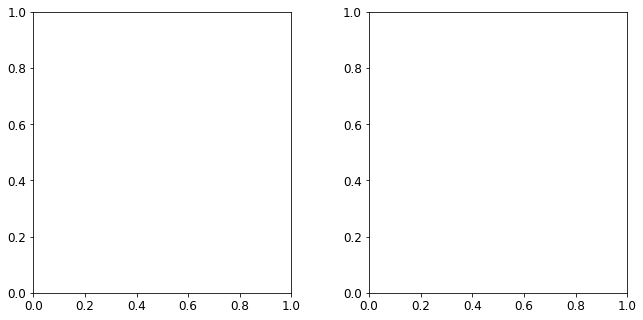

In [49]:
SST_pairs = (0,1),(1,2),(2,3),(3,4)
n_SSTpairs = len(SST_pairs)

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(11,5))

delta_E_all = []
delta_prQ_all = []
delta_intRH_all = []

# compute
for i_sim in range(n_sims-1):
    for i_SSTp in range(n_SSTpairs):
    
        i_SST0 = SST_pairs[i_SSTp][0]
        i_SST1 = SST_pairs[i_SSTp][1]
        SST0,SST1 = SSTs[i_SST0],SSTs[i_SST1]
        dSST = SST1-SST0
        
        col = SST_col[i_SST0+1]
        # Show points
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = col
        mw = 1
        if i_sim == 0:
            mw = 2
        
        # Panel (a)
        i_plot = 0
        ax = axs[i_plot]
        
        i_row = i_sim*n_SSTpairs + i_SSTp
        i_row_Dref = (n_sims-1)*n_SSTpairs + i_SSTp
        
        
        i_prQ = 4
        i_eff = 5
        
#         if i_row in rows_to_recompute:
#             continue
        if np.isnan(fc_contrib_array[i_row,i_eff]):
            continue
        
        # compute
        x = fc_contrib_array[i_row,i_eff] - fc_contrib_array[i_row_Dref,i_eff]
        y = fc_contrib_array[i_row,i_prQ] - fc_contrib_array[i_row_Dref,i_prQ]
        # save for linear regression
        delta_E_all.append(x)
        delta_prQ_all.append(y)
        # plot
        ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=col,markeredgewidth=mw)
        
        # Panel (b)
        i_plot = 1
        ax = axs[i_plot]
        
        # + reuse previous 
        y = x.copy()
        # Get integral of RH computed above for x
        x = (intRH_array[i_SST1,i_sim]/intRH_array[i_SST0,i_sim] - 1)*100/dSST - \
            (intRH_array[i_SST1,4]/intRH_array[i_SST0,4] - 1)*100/dSST
        # save for linear regression
        delta_intRH_all.append(x)
        # plot
        ax.plot(x,y,simtype_markers[i_sim], ms=8, markerfacecolor=mfc,markeredgecolor=col,markeredgewidth=mw)

titles = 'Departures from CC scaling',''
ylabels = r'$\delta P^Q - \delta P^Q\left(\mathcal{D}_{ref}\right)$  (%/K)',\
          r'$E-E\left(\mathcal{D}_{ref}\right)$ (%/K)'
xlabels = r'$E-E\left(\mathcal{D}_{ref}\right)$ (%/K)',\
          r'$\delta \langle RH\rangle^Q - \delta \langle RH\rangle^Q\left(\mathcal{D}_{ref}\right)$  (%/K)'
          
    
for i_ax in range(len(axs)):
    ax = axs[i_ax]
    ax.set_title(titles[i_ax])
    ax.set_ylabel(ylabels[i_ax])
    ax.set_xlabel(xlabels[i_ax])

# Linear fit for panel (a)
ax = axs[0]
slope, intercept, r_value, p_value, std_err = stats.linregress(delta_E_all,delta_prQ_all)
x = np.arange(-3,11,0.01)
y = intercept + slope*x
ax.plot(x,y,c='k',linewidth=1)
ax.text(0.05,0.92,'r = %.2f'%r_value,transform = ax.transAxes,fontsize=14)

# Linear fit for panel (b)
ax = axs[1]
slope, intercept, r_value, p_value, std_err = stats.linregress(delta_intRH_all,delta_E_all)
x = np.arange(-2,3,0.01)
y = intercept + slope*x
ax.plot(x,y,c='k',linewidth=1)
ax.text(0.05,0.92,'r = %.2f'%r_value,transform = ax.transAxes,fontsize=14)

plt.savefig(os.path.join(figuredir,'correlations_delta_P999_delta_eps_and_delta_eps_delta_intRH.pdf'),
                bbox_inches='tight')
plt.show()

### Show eps, M, intMuGamma over T

In [20]:
contrib = eps_array, intW_array, intMuGamma_array
contrib_name = 'eps','intW','intMuGamma'
contrib_labels = r'Efficiency $\varepsilon$',\
                  r'Effective vertical velocity $\langle w \rangle$ (m/s)',\
                  r'Thermodynamic factor $\langle \frac{w}{\langle w \rangle} \frac{\partial q_v^\star}{\partial z} \rangle$ (kg/m$^3$)'
contrib_col = 'g','b','r'

n_contribs = len(contrib_col)

[300 302 304 306 308] [ 0.01715527  0.01878125  0.02028387  0.02131855  0.02263337]
[300 302 304 306 308] [ 0.98327067  0.9907804   1.02551109  1.06897125  1.10060087]
[300 302 304 306 308] [ 0.37255088  0.3866829   0.39332897  0.40153478  0.40127845]
[300 302 304 306 308] [ 0.01780359  0.01818653  0.01533199  0.01667617  0.01633421]
[300 302 304 306 308] [ 0.90591857  0.88652083  0.88544426  0.9255311   1.04993078]
[300 302 304 306 308] [ 0.57610295  0.66224607  1.01510096  0.95400834  1.04638903]


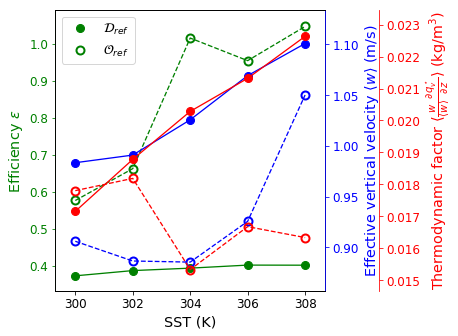

In [42]:

# ind_sims2plot = (0,4) # Oref, Dref
ind_sims2plot = (4,0) # Dref, Oref
# ind_sims2plot = (0,1,4) # Oref, FO, Dref



# fig, axs = plt.subplots(ncols=2,figsize=(11,5))
fig, ax_0 = plt.subplots(ncols=1,figsize=(5,5))

# Define axes
ax_eps = ax_0
ax_intW = ax_eps.twinx()
ax_intMuGamma = ax_eps.twinx()
axs = ax_eps,ax_intW,ax_intMuGamma

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in ind_sims2plot:
    
        simname = simname_patterns[i_sim]%SST
        
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        # Show each dot
#         for i_con in range(n_contribs):
        for i_con in (2,1,0):
            
            x = SSTs[i_SST]
            y = contrib[i_con][i_SST,i_sim]
            
            col = contrib_col[i_con]
            # Show points
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = col
            mw = 1
            if i_sim == 0:
                mw = 2
            # label
            lab = ''
            if i_con == i_SST == 0:
                lab = simtype_labels[i_sim]
            ax = getattr(thismodule,'ax_%s'%contrib_name[i_con])
            ax.plot(x,y,simtype_markers[i_sim], ms=8,
                    markerfacecolor=mfc,
                    markeredgecolor=col,
                    markeredgewidth=mw,
                    label=lab)
#                   linestyle=simtype_linetype[i_sim],c=col)

##--- Draw lines
for i_sim in ind_sims2plot:

#     simtype = simtypes[i_sim]

#             x_ssts,y_pr = getExponentialSSTCurve(i_sim,fracchange_mean_percIL,offset_percIL,iQref)
        #-- Recompute manually

#         for i_con in range(n_contribs):
    for i_con in (2,1,0):

        cont = contrib[i_con]

        # SSTs 
        sst_values = []
        contrib_values = []
        for i_SST in range(n_SSTs):
            if not (i_SST,i_sim) in sims2exclude:
                sst_values.append(SSTs[i_SST])
                simname = simname_patterns[i_sim]%SSTs[i_SST]
                contrib_values.append(cont[i_SST,i_sim])
        sst_values = np.array(sst_values)
        contrib_values = np.array(contrib_values)
        print(sst_values,contrib_values)

        # fit
#             slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(pr_values))
#         #-- Values to plot
#         x_ssts = np.linspace(sst_values[0]-1,sst_values[-1]+1,100)
#         y_pr = np.exp(slope*x_ssts+intercept)
        # Draw
#         lab = 'Exponential trend, '+simtype_labels[i_sim]+': %2.2f'%(slope*100)+' %/K'
#             lab = simtype_labels[i_sim]+': %2.2f'%(slope*100)+' %/K'

        # Get correct axis
        ax = getattr(thismodule,'ax_%s'%contrib_name[i_con])
        # Plot
        ax.plot(sst_values,contrib_values,linestyle=simtype_linetype[i_sim],
                linewidth=1.3,c=contrib_col[i_con])

ax.set_xlim((299.3,308.7))
ax.set_xlabel('SST (K)')

contrib_side = 'left','right','right'
for i_con in range(n_contribs):
    
    ax = getattr(thismodule,'ax_%s'%contrib_name[i_con])
    col = contrib_col[i_con]
    ax.spines[contrib_side[i_con]].set_color(col)
    ax.tick_params(axis='y', colors=col)
    ax.yaxis.label.set_color(col)
    ax.set_ylabel(contrib_labels[i_con])
    
ax_intMuGamma.spines["right"].set_position(("axes", 1.2))

ax_0.set_xlabel('SST (K)')
ax_0.legend(loc='best',fontsize=13)

##-- Adjust y-axes ranges
# # Same ratio
# y_shift = (0,0.36,0.27)
# f_ymin = [0.32]*3
# f_ymax = [1.01]*3
# for i in range(3):
#     ax = axs[i]
#     ymax = ax.get_ylim()[1]
#     ax.set_ylim((f_ymin[i]*ymax+y_shift[i]*ymax,f_ymax[i]*ymax+y_shift[i]*ymax))

# Different ratio
# f_ymin = (0.95,0.88,0.88)
f_ymin = (0.98,0.98,0.98)
f_ymax = (1.01,1.02,1.02)
for i in range(3):
    ax = axs[i]
    ymin,ymax = ax.get_ylim()
    ax.set_ylim((f_ymin[i]*ymin,f_ymax[i]*ymax))


plt.savefig(os.path.join(figuredir,'eps_intW_intMuGamme_all_SSTs_Oref_Dref.pdf'),
                bbox_inches='tight')
plt.show()

Show vertical velocity profiles
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg


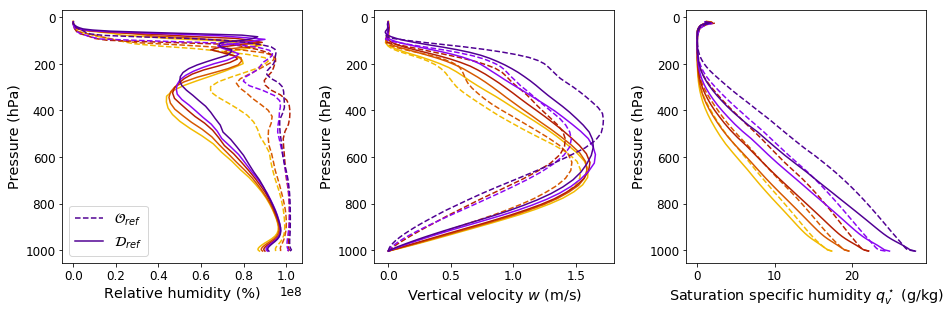

In [29]:
print("Show vertical velocity profiles")


fig, axs = plt.subplots(ncols=3,figsize=(16,4.5))

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
    
        simname = simname_patterns[i_sim]%SST
        
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        # Calculate w, qvstar, relhum profiles
        w_all = []
        qvstar_all = []
        relhum_all = []
        for iQ in range(iQref,iQmax):
            # vertical velocity
            w_all.append(prQ_prof_conditionals[simname]['W'][iQ])
            # thermodynamic profiles
            tabs_prof = prQ_prof_conditionals[simname]['TABS'][iQ]
            qv_prof = prQ_prof_conditionals[simname]['QV'][iQ]*1000
            p_prof = p_profile[simname]*100
            qvstar_prof = saturationSpecificHumidity(pres=p_prof,temp=tabs_prof)
            qvstar_all.append(qvstar_prof)
            relhum_prof = qv_prof/qvstar_prof*100
            relhum_all.append(relhum_prof)
        # compute mean profiles across percentiles
        w = np.nanmean(np.vstack(w_all),axis=0)
        qvstar = np.nanmean(np.vstack(qvstar_all),axis=0)
        relhum = np.nanmean(np.vstack(relhum_all),axis=0)
        
        pres = p_profile[simname]*100

        col = SST_col[i_SST]
        # Show points
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = col
        mw = 1
        if i_sim == 0:
            mw = 2
        # label
        lab = ''
        if SST == SSTs[-1]:
            lab = simtype_labels[i_sim]
        # Panel (a) - profiles of RH for reference runs
        if i_sim in (0,4):
            axs[0].plot(relhum,pres/100,c=col,linestyle=simtype_linetype[i_sim],label=lab)
            axs[1].plot(w,pres/100,c=col,linestyle=simtype_linetype[i_sim])
            axs[2].plot(qvstar*1000,pres/100,c=col,linestyle=simtype_linetype[i_sim])

for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('Pressure (hPa)')

axs[0].set_xlabel('Relative humidity (%)')
axs[1].set_xlabel(r'Vertical velocity $w$ (m/s)')
axs[2].set_xlabel(r'Saturation specific humidity $q_v^\star$ (g/kg)')

axs[0].legend(fontsize=14)

plt.savefig(os.path.join(figuredir,'profiles_prQext_RH_w_qvstar_all_SSTs_Oref_Dref.pdf'),
                bbox_inches='tight')
plt.show()

Show vertical velocity profiles
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg


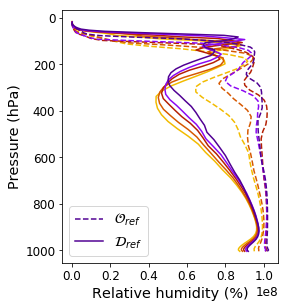

In [38]:
print("Show vertical velocity profiles")


fig, ax = plt.subplots(ncols=1,figsize=(4,4.5))

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
    
        simname = simname_patterns[i_sim]%SST
        
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        # Calculate w, qvstar, relhum profiles
        w_all = []
        qvstar_all = []
        relhum_all = []
        for iQ in range(iQref,iQmax):
            # vertical velocity
            w_all.append(prQ_prof_conditionals[simname]['W'][iQ])
            # thermodynamic profiles
            tabs_prof = prQ_prof_conditionals[simname]['TABS'][iQ]
            qv_prof = prQ_prof_conditionals[simname]['QV'][iQ]*1000
            p_prof = p_profile[simname]*100
            qvstar_prof = saturationSpecificHumidity(pres=p_prof,temp=tabs_prof)
            qvstar_all.append(qvstar_prof)
            relhum_prof = qv_prof/qvstar_prof*100
            relhum_all.append(relhum_prof)
        # compute mean profiles across percentiles
        w = np.nanmean(np.vstack(w_all),axis=0)
        qvstar = np.nanmean(np.vstack(qvstar_all),axis=0)
        relhum = np.nanmean(np.vstack(relhum_all),axis=0)
        
        pres = p_profile[simname]*100

        col = SST_col[i_SST]
        # Show points
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = col
        mw = 1
        if i_sim == 0:
            mw = 2
        # label
        lab = ''
        if SST == SSTs[-1]:
            lab = simtype_labels[i_sim]
        # Panel (a) - profiles of RH for reference runs
        if i_sim in (0,4):
            ax.plot(relhum,pres/100,c=col,linestyle=simtype_linetype[i_sim],label=lab)

ax.invert_yaxis()
ax.set_ylabel('Pressure (hPa)')

ax.set_xlabel('Relative humidity (%)')

ax.legend(fontsize=14)

plt.savefig(os.path.join(figuredir,'profiles_RH_at_prQ_all_SSTs_Oref_Dref.pdf'),
                bbox_inches='tight')
plt.show()

Show vertical velocity profiles
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg


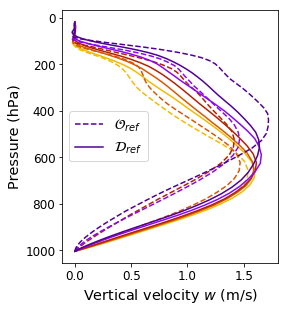

In [39]:
print("Show vertical velocity profiles")


fig, ax = plt.subplots(ncols=1,figsize=(4,4.5))

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
    
        simname = simname_patterns[i_sim]%SST
        
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        # Calculate w, qvstar, relhum profiles
        w_all = []
        qvstar_all = []
        relhum_all = []
        for iQ in range(iQref,iQmax):
            # vertical velocity
            w_all.append(prQ_prof_conditionals[simname]['W'][iQ])
            # thermodynamic profiles
            tabs_prof = prQ_prof_conditionals[simname]['TABS'][iQ]
            qv_prof = prQ_prof_conditionals[simname]['QV'][iQ]*1000
            p_prof = p_profile[simname]*100
            qvstar_prof = saturationSpecificHumidity(pres=p_prof,temp=tabs_prof)
            qvstar_all.append(qvstar_prof)
            relhum_prof = qv_prof/qvstar_prof*100
            relhum_all.append(relhum_prof)
        # compute mean profiles across percentiles
        w = np.nanmean(np.vstack(w_all),axis=0)
        qvstar = np.nanmean(np.vstack(qvstar_all),axis=0)
        relhum = np.nanmean(np.vstack(relhum_all),axis=0)
        
        pres = p_profile[simname]*100

        col = SST_col[i_SST]
        # Show points
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = col
        mw = 1
        if i_sim == 0:
            mw = 2
        # label
        lab = ''
        if SST == SSTs[-1]:
            lab = simtype_labels[i_sim]
        # Panel (a) - profiles of RH for reference runs
        if i_sim in (0,4):
            ax.plot(w,pres/100,c=col,linestyle=simtype_linetype[i_sim],label=lab)

ax.invert_yaxis()
ax.set_ylabel('Pressure (hPa)')

ax.set_xlabel(r'Vertical velocity $w$ (m/s)')

ax.legend(fontsize=14)

plt.savefig(os.path.join(figuredir,'profiles_w_at_prQ_all_SSTs_Oref_Dref.pdf'),
                bbox_inches='tight')
plt.show()

Combined figure with RH and W profiles and correlations

passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-r1-b150-sfcdisagg
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST300-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST302-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1
passing RCE_MPDATAxTKExCAMxSAM1MOM_4000x4000x15_256x256x64_TKE-SST304-radhomo-r1
passing RCE_MPDATAxTKExCAMx

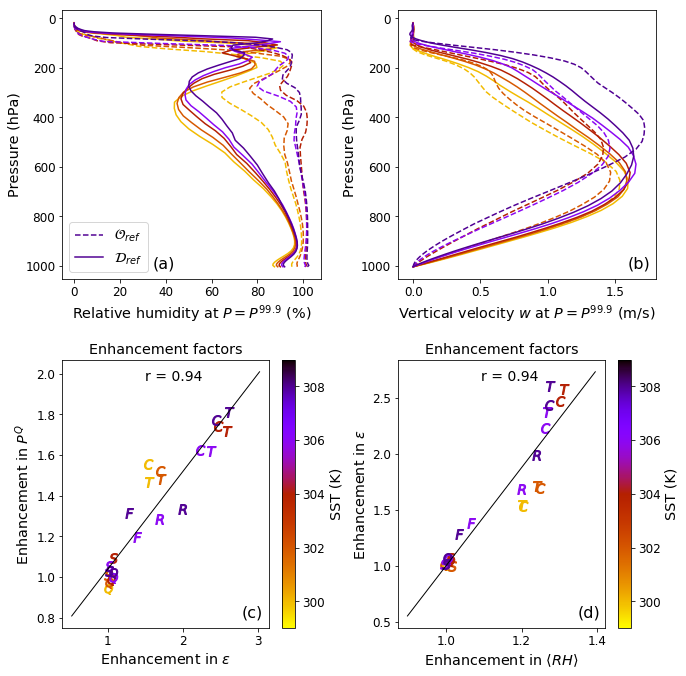

In [56]:
print("Combined figure with RH and W profiles and correlations")
print()


fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(11,11))


#####----------- Panels (a) and (b), vertical profiles of RH and W --------------#####
axs_profiles = axs[0]

for i_SST in range(n_SSTs):

    SST = SSTs[i_SST]
    
    for i_sim in range(n_sims):
    
        simname = simname_patterns[i_sim]%SST
        
        if (i_SST,i_sim) in sims2exclude:
            print("passing %s"%simname)
            continue
        
        # Calculate w, qvstar, relhum profiles
        w_all = []
        qvstar_all = []
        relhum_all = []
        for iQ in range(iQref,iQmax):
            # vertical velocity
            w_all.append(prQ_prof_conditionals[simname]['W'][iQ])
            # thermodynamic profiles
            tabs_prof = prQ_prof_conditionals[simname]['TABS'][iQ]
            qv_prof = prQ_prof_conditionals[simname]['QV'][iQ]/1000
            p_prof = p_profile[simname]*100
            qvstar_prof = saturationSpecificHumidity(pres=p_prof,temp=tabs_prof)
            qvstar_all.append(qvstar_prof)
            relhum_prof = qv_prof/qvstar_prof*100
            relhum_all.append(relhum_prof)
        # compute mean profiles across percentiles
        w = np.nanmean(np.vstack(w_all),axis=0)
        qvstar = np.nanmean(np.vstack(qvstar_all),axis=0)
        relhum = np.nanmean(np.vstack(relhum_all),axis=0)
        
        pres = p_profile[simname]*100

        col = SST_col[i_SST]
        # Show points
        if i_sim in (0,1,2):
            mfc = 'none'
        else:
            mfc = col
        mw = 1
        if i_sim == 0:
            mw = 2
        # label
        lab = ''
        if SST == SSTs[-1]:
            lab = simtype_labels[i_sim]
        # Panel (a) - profiles of RH for reference runs
        if i_sim in (0,4):
            axs_profiles[0].plot(relhum,pres/100,c=col,linestyle=simtype_linetype[i_sim],label=lab)
            axs_profiles[1].plot(w,pres/100,c=col,linestyle=simtype_linetype[i_sim])

for ax in axs_profiles:
    ax.invert_yaxis()
    ax.set_ylabel('Pressure (hPa)')

axs_profiles[0].set_xlabel(r'Relative humidity at $P=P^{99.9}$ (%)')
axs_profiles[1].set_xlabel(r'Vertical velocity $w$ at $P=P^{99.9}$ (m/s)')

axs_profiles[0].legend(fontsize=14)



#####----------- Panels (c) and (d), vertical profiles of RH and W --------------#####
axs_corr = axs[1]


ef_markers = "T","R","F","S","Q","C"

predictors = ef_eps_array, ef_intRH_array, ef_satDef_array, ef_intW_array, ef_intMuGamma_array, ef_prQ_array
predictors_labels = r'$\varepsilon$', r'$\langle RH \rangle$', r'$\langle 1-RH \rangle$',\
    r'$\langle W \rangle$', r'$\langle \mu\gamma \rangle$', r'$P^Q$'
predictors_names = 'eps','intRH','satDef','intW','intMuGamma','prQ'

# prQ vs eps
i_pred_x_s = 0,1
i_pred_y_s = 5,0

for i_plot,ax in zip(range(2),axs_corr):

    i_pred_x = i_pred_x_s[i_plot]
    i_pred_y = i_pred_y_s[i_plot]

    # Store values
    x_all = []
    y_all = []

    for i_SST in range(n_SSTs):

        SST = SSTs[i_SST]

        for i_ef in range(n_ef):

            simname = simname_patterns[i_sim]%SST

    #         print(simname)
            if (i_SST,ef_inds[i_ef][0]) in sims2exclude or (i_SST,ef_inds[i_ef][1]) in sims2exclude:
                print("passing %s"%simname)
    #             print(' passing')
                continue


            x = predictors[i_pred_x][i_SST,i_ef]
            y = predictors[i_pred_y][i_SST,i_ef]
            x_all.append(x)
            y_all.append(y)

            col = SST_col[i_SST]
            # Show points
            if i_sim in (0,1,2):
                mfc = 'none'
            else:
                mfc = col
            mw = 1
            if i_sim == 0:
                mw = 2

    #         ax.plot(x,y,ef_markers[i_ef], ms=8, markerfacecolor=mfc,markeredgecolor=col,markeredgewidth=mw)
            ax.scatter(x,y,marker="$ {} $".format(ef_markers[i_ef]), c=col,s=100)


    # compute range of values to plot for regression line
    fac = 0.3
    x_range = np.min(x_all),np.max(x_all)
    dxrange = x_range[1] - x_range[0]
    x_range2plot = x_range[0]-fac*dxrange, x_range[1]+fac*dxrange

    # slope, intercept, r_value, p_value, std_err = stats.linregress(intRH_all,eps_all)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_all,y_all)
    x = np.arange(x_range2plot[0],x_range2plot[1],0.1)
    y = intercept + slope*x
    ax.plot(x,y,c='k',linewidth=1)
    ax.text(0.4,0.92,'r = %.2f'%r_value,transform = ax.transAxes,fontsize=14)


    # Color bar
    cax, _ = matplotlib.colorbar.make_axes(ax)
    normalize = matplotlib.colors.Normalize(vmin=SSTmin, vmax=SSTmax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,label='SST (K)')

    # ax.set_xlabel(r'Enhancement in saturation deficit $\langle 1-RH \rangle$')
    ax.set_xlabel(r'Enhancement in %s'%(predictors_labels[i_pred_x]))
    ax.set_ylabel(r'Enhancement in %s'%(predictors_labels[i_pred_y]))
    ax.set_title(r'Enhancement factors')

##-- panel numbers
axs[0,0].text(0.35,0.04,'(a)',transform = axs[0,0].transAxes,fontsize=16)
axs[0,1].text(0.89,0.04,'(b)',transform = axs[0,1].transAxes,fontsize=16)
axs[1,0].text(0.87,0.04,'(c)',transform = axs[1,0].transAxes,fontsize=16)
axs[1,1].text(0.87,0.04,'(d)',transform = axs[1,1].transAxes,fontsize=16)

plt.savefig(os.path.join(figuredir,'profiles_RH_w_and_corr_prQ_eps_intRH.pdf'),
                bbox_inches='tight')
plt.show()

In [44]:
print(relhum)

[  9.18914840e+07   9.13597119e+07   9.13373070e+07   9.17711381e+07
   9.25380677e+07   9.35755302e+07   9.47618813e+07   9.58958043e+07
   9.67499545e+07   9.72545784e+07   9.74454345e+07   9.73325946e+07
   9.69405242e+07   9.63711010e+07   9.56995942e+07   9.48477766e+07
   9.37733518e+07   9.25183111e+07   9.09068163e+07   8.93387789e+07
   8.73933094e+07   8.48140615e+07   8.23832700e+07   7.99530533e+07
   7.69390228e+07   7.39507457e+07   7.03318023e+07   6.90409575e+07
   6.66507961e+07   6.45456470e+07   6.21685617e+07   5.90006928e+07
   5.61460905e+07   5.31635645e+07   5.09597788e+07   5.00620431e+07
   5.02910720e+07   5.15619420e+07   5.42282821e+07   5.81283066e+07
   6.28431924e+07   6.76462174e+07   7.24209442e+07   7.39900922e+07
   7.43719904e+07   6.93788569e+07   6.84963263e+07   6.94395006e+07
   7.94976665e+07   8.43447849e+07   8.66353570e+07   7.91896775e+07
   5.61491442e+07   3.44684696e+07   1.71291466e+07   8.91813179e+06
   4.65323283e+06   3.01082099e+06

## Thermodynamic-dynamic decomposition that uses all SSTs at once

$$P^Q \approx \exp\left(a^Q T + b^Q\right)$$

In [ ]:
print("Regress log of precipitation efficiency onto SST")

fracchange_mean_eps = {}
offset_eps = {}

for i_sim in range(n_sims):
    
    key = simtypes[i_sim]
    print(' . ',key)
    
    fracchange_mean_eps[key] = np.nan*np.zeros((iQmax,))
    offset_eps[key] = np.nan*np.zeros((iQmax,))
        
    # SST - eps to consider (removing failed simulations)
    sst_values = []
    eps_values = []
    for i_SST in range(n_SSTs):
        if not (i_SST,i_sim) in sims2exclude:

            # sst
            SST = SSTs[i_SST]
            sst_values.append(SST)
            # eps
            simname = simname_patterns[i_sim]%SST
            eps = computePrecipitationEfficiencyFromSimname(simname)
            print(SST, eps)
            eps_values.append(eps)

    # Regress ln(eps) against T for percentiles
    slope, intercept, r_value, p_value, std_err = stats.linregress(sst_values,np.log(eps_values))
    fracchange_mean_eps[key] = slope
    offset_eps[key] = intercept


In [ ]:
enhancementFactor(list(fracchange_mean_eps.values()),list(offset_eps.values()),306)